<div style="border-radius: 10px; box-shadow: 0px 0px 2px; border: 1px solid; background:#eaeaea; position: relative; padding: 10px; padding-left: 10px;">
<h7 style="color:black; margin-bottom:20px"> 

# <span style="color:#143a51">Анализ поведения пользователей мобильного приложения <span> 
    
---
---   
    
**Заказчик:**    
продакт-менеджер мобильного приложения для размещения объявлений о продаже товаров от частных лиц.

**Цель:** необходимо исследовать предоставленные данные, найти связь целевого события (просмотр контактов) с другими действиями пользователей и проанализировать поведение пользователей, совершивших просмотр контактов  с целью адаптация приложения по целевой и смежной аудитории и получения гипотез о том как можно было бы улучшить приложение с точки зрения пользовательского опыта.
    
---     
    
1. Открытие данных
2. Предобработка данных
3. Исследовательский анализ данных
4. Анализ поведения пользователей
5. Расчет метрик
6. Проверка гипотез
5. Вывод

---
[Ссылка на дашборд](https://public.tableau.com/app/profile/kristina2465/viz/Dash_mobile_app/Dashboard2) 
---    
[Ссылка на презентацию](https://disk.yandex.ru/i/8wM-Jik48QcE1Q) 
--- 

##  Открытие данных
<a id="start"></a>

In [1]:
# импортируем библиотеки
import pandas as pd
import numpy as np
import re
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gridspec
from plotly import graph_objects as go
import chart_studio.plotly as py
from scipy import stats as st
import scipy.stats as stats
import math as mth
from tqdm.auto import tqdm

# устанавливаем параметры отображение 
pd.options.display.max_columns = 40 


In [2]:
# считываем данные 

mobile = pd.read_csv('mobile_dataset.csv')
sources = pd.read_csv('mobile_sources.csv')

In [3]:
# создадим функцию start
def start(df):
    """Функция выводит основную информацию по даиафрейму

    Args:
        df: датафрейм
    """
    display(df.head())
    print(df.info())
    print()
    print('Размер таблицы:', df.shape)
    print()
    print('Количество пропусков:', round(df.isna().sum()), sep='\n')
    print()
    print('Наличие дубликатов:', df.duplicated().sum())

In [4]:
# вызовем функцию start, в качестве аргумента датафрейм mobile
start(mobile)


event.time   event.name  \
0  2019-10-07 00:00:00.431357  advert_open   
1  2019-10-07 00:00:01.236320    tips_show   
2  2019-10-07 00:00:02.245341    tips_show   
3  2019-10-07 00:00:07.039334    tips_show   
4  2019-10-07 00:00:56.319813  advert_open   

                                user.id  
0  020292ab-89bc-4156-9acf-68bc2783f894  
1  020292ab-89bc-4156-9acf-68bc2783f894  
2  cf7eda61-9349-469f-ac27-e5b6f5ec475c  
3  020292ab-89bc-4156-9acf-68bc2783f894  
4  cf7eda61-9349-469f-ac27-e5b6f5ec475c

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74197 entries, 0 to 74196
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   event.time  74197 non-null  object
 1   event.name  74197 non-null  object
 2   user.id     74197 non-null  object
dtypes: object(3)
memory usage: 1.7+ MB
None

Размер таблицы: (74197, 3)

Количество пропусков:
event.time    0
event.name    0
user.id       0
dtype: int64

Наличие дубликатов: 0


In [5]:
# вызовем функцию start, в качестве аргумента датафрейм sources
start(sources)

userId  source
0  020292ab-89bc-4156-9acf-68bc2783f894   other
1  cf7eda61-9349-469f-ac27-e5b6f5ec475c  yandex
2  8c356c42-3ba9-4cb6-80b8-3f868d0192c3  yandex
3  d9b06b47-0f36-419b-bbb0-3533e582a6cb   other
4  f32e1e2a-3027-4693-b793-b7b3ff274439  google

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4293 entries, 0 to 4292
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   userId  4293 non-null   object
 1   source  4293 non-null   object
dtypes: object(2)
memory usage: 67.2+ KB
None

Размер таблицы: (4293, 2)

Количество пропусков:
userId    0
source    0
dtype: int64

Наличие дубликатов: 0


**Вывод:** 

В датафрейме **mobile** :
- `74197` строк и `3` столбца  
- пропусков и явных дубликатов не выявлено
- нужно заменить тип данных в столбце event.time
- нужно перевести названия столбцов в snake_case

В датафрейме **sources** :
- `4293` строк и `2` столбца  
- пропусков и явных дубликатов не выявлено
- нужно перевести название столбца 'userId' в snake_case

Стоит объединить датафреймы

## Предобработка данных
<a id="preprocessing"></a>

In [6]:
# приведем названия столбцов в snake_case
mobile.columns = [col.replace('.', '_') for col in mobile.columns]
print(mobile.columns)

sources = sources.rename(columns={'userId': 'user_id'})
print(sources.columns)

Index(['event_time', 'event_name', 'user_id'], dtype='object')
Index(['user_id', 'source'], dtype='object')


In [7]:
# поменяем тип данных на  datetime
mobile['event_time'] = pd.to_datetime(mobile['event_time'], format = '%Y-%m-%d %H:%M:%S')

# создадим новый столбец 'event_dt', содержащий дату события
mobile['event_dt'] = mobile['event_time'].dt.date

Посмотрим на столбцы с id пользователей, подготовим их для присоединения таблиц

In [8]:
# удалим возможные лишние пробелы в начале и в конце строки у столбцов с  user_id
# на всякий случай переведем в один формат 'str'
mobile['user_id'] = mobile['user_id'].astype('str').str.strip()
sources['user_id'] = sources['user_id'].astype('str').str.strip()

# посмотрим на кол-во уникальных id пользователей 
print('Количество уникальных пользователей в mobile: ', mobile['user_id'].nunique())
print('Количество уникальных пользователей в sources: ', sources['user_id'].nunique())
print('Количество совпадений уникальных id: ', len(set(mobile['user_id']).intersection(set(sources['user_id']))))

Количество уникальных пользователей в mobile:  4293
Количество уникальных пользователей в sources:  4293
Количество совпадений уникальных id:  4293


Все в порядке, можно объединять таблицы по столбцу 'user_id'

In [9]:
# объединим датафреймы в переменную df
df = mobile.merge(sources, on='user_id', how='left')
df = df[['user_id', 'event_name', 'event_time', 'event_dt', 'source']]
start(df)

user_id   event_name  \
0  020292ab-89bc-4156-9acf-68bc2783f894  advert_open   
1  020292ab-89bc-4156-9acf-68bc2783f894    tips_show   
2  cf7eda61-9349-469f-ac27-e5b6f5ec475c    tips_show   
3  020292ab-89bc-4156-9acf-68bc2783f894    tips_show   
4  cf7eda61-9349-469f-ac27-e5b6f5ec475c  advert_open   

                  event_time    event_dt  source  
0 2019-10-07 00:00:00.431357  2019-10-07   other  
1 2019-10-07 00:00:01.236320  2019-10-07   other  
2 2019-10-07 00:00:02.245341  2019-10-07  yandex  
3 2019-10-07 00:00:07.039334  2019-10-07   other  
4 2019-10-07 00:00:56.319813  2019-10-07  yandex

<class 'pandas.core.frame.DataFrame'>
Int64Index: 74197 entries, 0 to 74196
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     74197 non-null  object        
 1   event_name  74197 non-null  object        
 2   event_time  74197 non-null  datetime64[ns]
 3   event_dt    74197 non-null  object        
 4   source      74197 non-null  object        
dtypes: datetime64[ns](1), object(4)
memory usage: 3.4+ MB
None

Размер таблицы: (74197, 5)

Количество пропусков:
user_id       0
event_name    0
event_time    0
event_dt      0
source        0
dtype: int64

Наличие дубликатов: 0


Кол-во строк в таблице df - 74197, что совпадает с кол-вом строк таблицы mobile

In [10]:
# посмотрим на столбец 'event_name'
df['event_name'].value_counts(normalize=True)

tips_show        0.539847
photos_show      0.134938
advert_open      0.083076
contacts_show    0.059975
map              0.052307
search_1         0.047253
favorites_add    0.019098
search_5         0.014138
tips_click       0.010971
search_4         0.009448
contacts_call    0.007291
search_3         0.007035
search_6         0.006200
search_2         0.004367
search_7         0.002992
show_contacts    0.001065
Name: event_name, dtype: float64

Больше половины от всех событий приходится на tips_show (увидел рекомендованные объявления). Все остальные значительно меньше 

Нужно объединить в одно значение show_contacts и contacts_show - это одно и тоже событие. А также объединить все действия связанных с поиском в одно, так доля многих мала 

In [11]:
# заменим show_contacts на contacts_show 
df['event_name'] = df['event_name'].replace('show_contacts', 'contacts_show')

# создадим список с со всеми событиями search
s = re.findall('\w+\d', ','.join(list(df['event_name'].unique())))
print(s)
df['event_name'] = df['event_name'].replace(s, 'search')
df['event_name'].value_counts()

['search_4', 'search_5', 'search_1', 'search_2', 'search_3', 'search_6', 'search_7']


tips_show        40055
photos_show      10012
search            6784
advert_open       6164
contacts_show     4529
map               3881
favorites_add     1417
tips_click         814
contacts_call      541
Name: event_name, dtype: int64

In [12]:
# какие события были первыми для пользователей
# отсоритируем по пользователю и времени события по возрастанию
df = df.sort_values(by=['user_id', 'event_time'])
df.groupby('user_id')['event_name'].first().value_counts()

tips_show        1398
search           1160
map               807
photos_show       560
contacts_show     179
advert_open       127
favorites_add      49
tips_click         13
Name: event_name, dtype: int64

У нас есть 179 пользователей, для которых contacts_show стало первым событием. На первом месте "увидел рекомендованное объявление". Действие contacts_call не было первым событие у пользователя. Так как первое событие у пользователя может быть любым, явных ошибок нет

In [13]:
# посмотрим есть ли пользователи, совершившие всего 1 событие за весь период
print('Кол-во пользователей, совершивших всего 1 событие: ', \
      df.groupby('user_id', as_index=False)['event_name'].count().query('event_name == 1').shape[0])

Кол-во пользователей, совершивших всего 1 событие:  65


In [14]:
# посмотрим какие события совершали пользователи с 1 событием
user_event_1 = df.groupby('user_id', as_index=False)['event_name'].count()\
                 .query('event_name == 1')['user_id'].to_list()
df[df['user_id'].isin(user_event_1)]['event_name'].value_counts()

tips_show        30
map              16
search            8
contacts_show     6
photos_show       4
advert_open       1
Name: event_name, dtype: int64

30 пользователей увидели рекомендованное объявление и видимо разочаровались в предложенных товарах. 6 пользователей посмотрели контакты и далее других событий у них не последовало, возможно они получили ссылку на контакт от других пользователей.

In [15]:
# посмотрим на столбец 'source'
df['source'].value_counts(normalize=True)

yandex    0.462094
google    0.275550
other     0.262356
Name: source, dtype: float64

In [16]:
# проверим нет ли ошибок, когда на один id приходится больше одного источника
df.groupby('user_id', as_index=False)['source'].nunique().query('source > 1')

Empty DataFrame
Columns: [user_id, source]
Index: []

Все в норме. Чаще всего, в 46% случаев, источником  установки приложения является yandex.

In [17]:
# посмотрим на минимальную и максимальную дату 
display(df['event_time'].agg(['min','max']))

min   2019-10-07 00:00:00.431357
max   2019-11-03 23:58:12.532487
Name: event_time, dtype: datetime64[ns]

Данные представлены за 28 дней: с 7 октября 2019 года по 3 ноября 2019 года (включительно).

In [18]:
# создадим столбец 'diff_time' с временем между событиями с секундах, ранее мы отсортировали датафрейм

#df = df.sort_values(by=['user_id', 'event_time'])
df['diff_time'] =  df.groupby('user_id')['event_time'].diff().dt.seconds

# посмотрим на распределение 
df['diff_time'].describe(percentiles=[.85, .88, .90, .92, .95, .99])

count    69904.000000
mean      2928.536879
std      12589.872536
min          0.000000
50%         70.000000
85%        373.000000
88%        594.000000
90%        986.000000
92%       2341.000000
95%      13368.100000
99%      77338.650000
max      86383.000000
Name: diff_time, dtype: float64

В [AppMetrica](https://appmetrica.yandex.ru/docs/quick-start/concepts/glossary.html)  дефолтным значением установлен таймаут с минимальный возможным значением в 10 сек.  В [Яндекс Метрика](https://yandex.ru/support/metrica/general/glossary.html) по дефолту установлено 30 мин, т.е 1800 сек., что попадает в промежуток между 90 и 92 прецентилем.  
Поэтому за **`таймаут`** сесии возьмем время в **`30 мин.`**

In [19]:
# определим разницу 30 мин для каждого пользователя с накопительной суммой, ранее мы отсортировали датафрейм
g = (df.groupby('user_id')['event_time'].diff() > pd.Timedelta('30Min')).cumsum()

# создаем id сессий
df['session_id'] = df.groupby(['user_id', g], sort=False).ngroup() + 1
print('Кол-во сессий: ', df['session_id'].nunique())
print('Кол-во сессий с целевым событием: ', df[df['event_name'] == 'contacts_show']['session_id'].nunique())
print('Доля сессий с целевым событием (%): ', round(df[df['event_name'] == 'contacts_show']['session_id'].nunique() /
     df['session_id'].nunique()*100, 1))

Кол-во сессий:  10368
Кол-во сессий с целевым событием:  1703
Доля сессий с целевым событием (%):  16.4


In [20]:
# создадим столбец session_time с длительностью сессии
df['session_time'] = df.groupby(['session_id'])['event_time'].transform(lambda x: x.max() - x.min())
df['session_time'] = df['session_time'].dt.seconds

# добавим новый столбец, показывающий есть или нет целевое действие в сессиии
df['target_session'] = df.groupby('session_id')['event_name'].transform(lambda x: (x == 'contacts_show').any()) * 1

# добавим столбец, показывающий совершал или нет целевое действие пользователь
df['target_user'] = df.groupby('user_id')['event_name'].transform(lambda x: (x == 'contacts_show').any()) * 1

# добавим столбец, показывающий совершал или нет целевое действие пользователь в этот день
df['target_user_day'] = df.groupby(['user_id', 'event_dt'])['event_name']\
                          .transform(lambda x: (x == 'contacts_show').any()) * 1

# добавим столбец, с датой начала сессии
df['session_start_dt'] = df.groupby('session_id')['event_dt'].transform(lambda x: x.min())

# проверим полученный результат
df[df['user_id'] == '00157779-810c-4498-9e05-a1e9e3cedf93'].head()

user_id   event_name  \
31632  00157779-810c-4498-9e05-a1e9e3cedf93       search   
31636  00157779-810c-4498-9e05-a1e9e3cedf93       search   
31640  00157779-810c-4498-9e05-a1e9e3cedf93       search   
31655  00157779-810c-4498-9e05-a1e9e3cedf93  photos_show   
31659  00157779-810c-4498-9e05-a1e9e3cedf93  photos_show   

                      event_time    event_dt  source  diff_time  session_id  \
31632 2019-10-19 21:34:33.849769  2019-10-19  yandex        NaN           5   
31636 2019-10-19 21:35:19.296599  2019-10-19  yandex       45.0           5   
31640 2019-10-19 21:36:44.344691  2019-10-19  yandex       85.0           5   
31655 2019-10-19 21:40:38.990477  2019-10-19  yandex      234.0           5   
31659 2019-10-19 21:42:13.837523  2019-10-19  yandex       94.0           5   

       session_time  target_session  target_user  target_user_day  \
31632          1520               0            1                0   
31636          1520               0            1                0   
31640          1520               0            1                0   
31655          1520               0            1                0   
31659          1520               0            1                0   

      session_start_dt  
31632       2019-10-19  
31636       2019-10-19  
31640       2019-10-19  
31655       2019-10-19  
31659       2019-10-19

In [21]:
df['target_user_day'] = df.groupby(['user_id', 'event_dt'])['event_name'].transform(lambda x: (x == 'contacts_show').any()) * 1

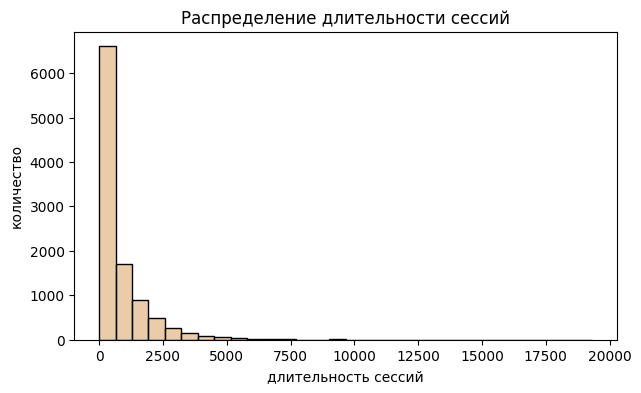

In [22]:
# создадим список цветов
colors = ['#a8bac0','#ac9c97', '#e5bc8c', '#bbcfd6', '#ac9c97', '#aeb2a9']
# посмотрим на гистограмму длительности сессий
plt.figure(figsize=(7, 4))
sns.histplot(df.groupby('session_id')['session_time'].min(), color=colors[2], bins=30)
plt.xlabel('длительность сессий', fontsize='10')
plt.ylabel('количество', fontsize='10')
plt.xticks(fontsize='10')
plt.yticks(fontsize='10')
plt.title('Распределение длительности сесcий', fontsize='12')
plt.show()

In [23]:
# применим метод describe() для длительности сессий
df.groupby('session_id')['session_time'].min().describe(percentiles=[.1, .15, .2, .25, .75, .95, .99])

count    10368.000000
mean       772.276620
std       1191.543244
min          0.000000
10%          0.000000
15%          0.000000
20%          0.000000
25%         21.000000
50%        335.000000
75%       1045.250000
95%       2911.000000
99%       5537.330000
max      19318.000000
Name: session_time, dtype: float64

По гистограмме видно, что большинство сессий не превышают 15 мин. Виден длинный хвост, только 5% всех сессий длительностью более 2911 сек(48 мин) и 1% более полутора часа - 5537 сек.   
Среднее значение равно почти 13 мин.(772 сек), медиана 335 сек, чуть более 5 мин. Выбросы на данном этапе удалять не будем, но дальше при анализе будем смотреть и на среднее, и на медиану.

Также стоит отметить, что 20% сессий имеют длительность 0 сек.   
В Яндекс Метрике отказом считается посещение, в котором пользователь просмотрел всего одну страницу и посвятил ее просмотру менее 15 секунд.  
Посмотрим много ли у нас нас сессий  меньше 15 секунд и с 1 событием 

In [24]:
# находим сессии продолжительностью менее 15 сек и за это время совершил  1 событие
session_short = df.groupby(['user_id','session_id']).agg({'session_time': ['min', 'count']})
session_short.columns = ['_'.join(col).strip() for col in session_short.columns.values]
session_short = session_short.query('session_time_min < 15 & session_time_count == 1').reset_index()

print('Кол-во сессий длительность менее 15 сек и с 1 событием: ', session_short['session_id'].count())
print('Доля таких сессий от кол-ва всех сессий(%): ', \
      round(session_short['session_id'].count() / df['session_id'].nunique() * 100))
print('Доля пользователей(%), у которых были такие сессии: ', \
      round(session_short['user_id'].nunique() / df['user_id'].nunique() * 100))

Кол-во сессий длительность менее 15 сек и с 1 событием:  2088
Доля таких сессий от кол-ва всех сессий(%):  20
Доля пользователей(%), у которых были такие сессии:  26


Таких сессий 20 %  и наблюдались они у 26 % пользователей, удалять их не будем, так как  сам заказчик не предоставил информацию, какие параметры учитывать при анализе сессий. Но сообщить об этом нужно, возможно есть какие-то технические проблемы.

In [25]:
# посмотрим какие действия совершались в сессиях менее 15 сек и с 1 событием
df[df['session_id'].isin(session_short['session_id'].unique())]['event_name'].value_counts()

tips_show        892
photos_show      513
search           377
contacts_show    124
map               97
advert_open       45
favorites_add     30
tips_click        10
Name: event_name, dtype: int64

Видно, что есть такие короткие сессиии с contacts_show, их меньше 10% от всех сессии с целевым событием

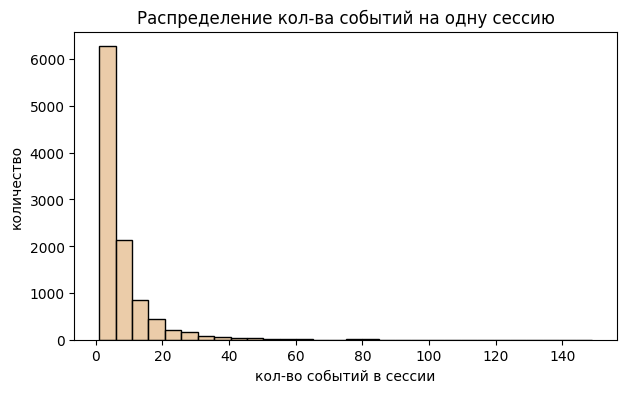

In [26]:
# посмотрим на гистограмму распределения кол-ва событий на одну сессию
plt.figure(figsize=(7, 4))
sns.histplot(df.groupby('session_id')['event_name'].count(), color=colors[2], bins=30)
plt.xlabel('кол-во событий в сессии', fontsize='10')
plt.ylabel('количество', fontsize='10')
plt.xticks(fontsize='10')
plt.yticks(fontsize='10')
plt.title('Распределение кол-ва событий на одну сессию', fontsize='12')
plt.show()

Распределение схоже с длительностью сессий, что логично. Ожидаемо больше всего сессий с небольшим кол-вом событий, ранее мы выявляли, что у нас  20% сессий с 1 событием. Также есть выбросы) Кто-то усердно что-то ищет для покупки или просто любит проводить время за просмотром товаров.

In [27]:
# применим метод describe() для кол-ва событий в каждой сессии
df.groupby('session_id')['event_name'].count().describe(percentiles=[.1, .15, .2, .25, .75, .95, .99])

count    10368.000000
mean         7.156346
std          9.581106
min          1.000000
10%          1.000000
15%          1.000000
20%          1.000000
25%          2.000000
50%          4.000000
75%          9.000000
95%         24.000000
99%         47.000000
max        149.000000
Name: event_name, dtype: float64

Медиана равна 4, среднее значение 7. Только 5 % сессий состоят из 24 событий и выше.

Посмотрим на 1 % сесиии с самым большим кол-вом событий, а особенно те сессии, где все события состоят из одного действия.

In [28]:
# посмотрим на сессии с кол-вом событий более 99 пренцентиля
big_session = (df.groupby('session_id', as_index=False)['event_name']
               .count()
               .query('event_name > 47')['session_id']
               .to_list()
              )
print('Кол-во сессий с кол-вом событий > 47: ' , len(big_session))

# посмотрим на сессиии с большим кол-вом событий, где все события состоят из одного действия 
big_session_1 = (
    df[df['session_id'].isin(big_session)]
   .groupby('session_id', as_index=False)['event_name'].nunique()
   .query('event_name == 1')['session_id'].to_list()
                )
print('Кол-во сессий c кол-вом событий только из одного действия > 47:  ' ,len(big_session_1))
df[df['session_id'].isin(big_session_1)].head()

Кол-во сессий с кол-вом событий > 47:  100
Кол-во сессий c кол-вом событий только из одного действия > 47:   13


user_id     event_name  \
22719  0a59892f-3578-484b-af84-eb3b2298fb8c  contacts_show   
22740  0a59892f-3578-484b-af84-eb3b2298fb8c  contacts_show   
22743  0a59892f-3578-484b-af84-eb3b2298fb8c  contacts_show   
22748  0a59892f-3578-484b-af84-eb3b2298fb8c  contacts_show   
22766  0a59892f-3578-484b-af84-eb3b2298fb8c  contacts_show   

                      event_time    event_dt  source  diff_time  session_id  \
22719 2019-10-16 13:48:40.215986  2019-10-16  yandex     2256.0         430   
22740 2019-10-16 13:54:56.487276  2019-10-16  yandex      376.0         430   
22743 2019-10-16 13:57:07.200943  2019-10-16  yandex      130.0         430   
22748 2019-10-16 13:57:55.292586  2019-10-16  yandex       48.0         430   
22766 2019-10-16 14:03:05.932591  2019-10-16  yandex      310.0         430   

       session_time  target_session  target_user  target_user_day  \
22719         10612               1            1                1   
22740         10612               1            1                1   
22743         10612               1            1                1   
22748         10612               1            1                1   
22766         10612               1            1                1   

      session_start_dt  
22719       2019-10-16  
22740       2019-10-16  
22743       2019-10-16  
22748       2019-10-16  
22766       2019-10-16

Видно, что есть сессия, которая состоит только из просмотра контактов. Возможно стоит ее рассматривать, как бот-атаку с целью получения контактов. Точного ответа я не знаю, поэтому данные таких сессии не удаляем.

Медиана равна 4, среднее значение 7. Только 5 % сессий состоят из 24 событий и выше. Такие сессии также не будем удалять, такие пользователи являются лояльными

**Вывод:** При предобработке мы:
- привели к snake_case наименования столбцов 
- привели тип данных в столбце 'event_time' к формату даты и времени
- присоединили таблицы
- в столбце 'event_name' нашли неявные дубликаты show_contacts и contacts_show, объединили в одно действие contacts_show
- в столбце 'event_name' все действия search_1 — search_7 заменили на search
- определили таймаут сессии в 30 мин
- создади новые столбцы с session_id и time_session (временем каждого события в разрезе сессии)
- данные не удаляли, кол-во строк в таблице df - 74197  

Выявили:
* данные представлены с 7 октября 2019 года по 3 ноября 2019 года (включительно)
* кол-во уникальных пользователей - 4293
* кол-во сессий - 10368
* кол-во сессий с целевым событием:  1703 (16,4 %)
* кол-во пользователей, совершивших всего 1 событие - 65
* доля сессий с длительностью менее 15 сек и с 1 событием -  20 %
* более половины событий (54%) приходится на tips_show (увидел рекомендованные объявления)
* cреднее значение длительности сессии составляет почти 13 мин.(772 сек), медиана 335 сек
* cреднее значение кол-ва событий на сессию - 7, медиана - 4

## Исследовательский анализ данных
<a id="preprocessing"></a>

#### Распределение кол-ва пользователей, событий, сессий по дням 
<a id="preprocessing"></a>

In [29]:
# создадим функцию для отображения значений на графиках
def signature(chart, n):
    for p in chart.patches:
        chart.annotate(n %  p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', fontsize=8, color='black', xytext=(0, 5),
                 textcoords='offset points')

In [30]:
# создадим функцию plot_bar_chart 

def plot_bar_chart(df, y, subtit, y1, x2, size_ticks, rot):
    
    """Функция строит столбчатую диаграмму

    Args:
        df: датафрейм, подготовленный для графиков
        y: предел оси у
        subtit: заголовок
        y1, x2: координаты расположения  subtit
        size_ticks: размер шрифта xticks
        rot: градусы расположения xticks
    """

    chart = df.plot(kind='bar', 
                width=0.83, 
                color= '#a8bac0', 
                figsize=(15,6), legend=False)

    # убираем границы графика
    axes = plt.gca() 
    axes.spines['top'].set_visible(False)
    axes.spines['left'].set_visible(False)
    axes.spines['right'].set_visible(False)
    axes.tick_params(left=False)
    # настройка осей
    plt.xticks(fontsize= size_ticks, ha='center', rotation=rot)
    plt.yticks(color='white')
    plt.ylim(0, y)
    plt.xlabel('')
    plt.ylabel('')
    # вызов функции signature для подписи значений
    signature(chart, "%.0f")
    # отображение заголовка
    plt.suptitle(subtit, y=y1, x=x2,  fontsize=14)
    plt.title('с 07.10.2019 г. по 03.11.2019 г. \n ', fontsize='12', loc='left')
    plt.show()

In [31]:
# создадим столбец с красивым отображением дат на графиках
df['dt_to_chart'] = pd.to_datetime(df['event_dt']).dt.strftime('%d %b')

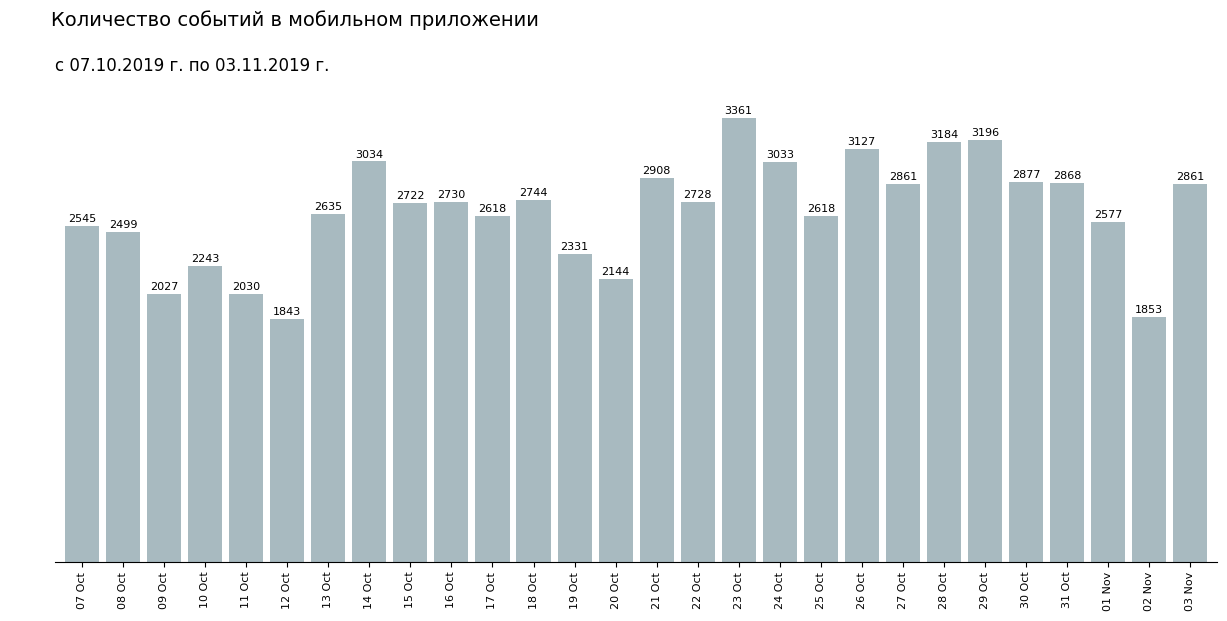

In [32]:
# посмотрим на распределение кол-ва событий по дням
t = df.groupby(['event_dt', 'dt_to_chart'], as_index=False)['event_name'].count()
t = t.drop('event_dt', axis=1).set_index('dt_to_chart')
# вызовем функцию plot_bar_chart
plot_bar_chart(t, 3500, 'Количество событий в мобильном приложении', 1.03, 0.285, '8', 90)

In [33]:
# найдем среднее кол-во событий в день за представленный период
print('Среднее кол-во событий в день: ', round(df.groupby('event_dt')['event_name'].count().mean()))

Среднее кол-во событий в день:  2650


Значение количества событий в день варьировалось от 1843 до 3361, среднее значение составляет 2650. На выходных днях от мечается снижение кол-ва просмотров.

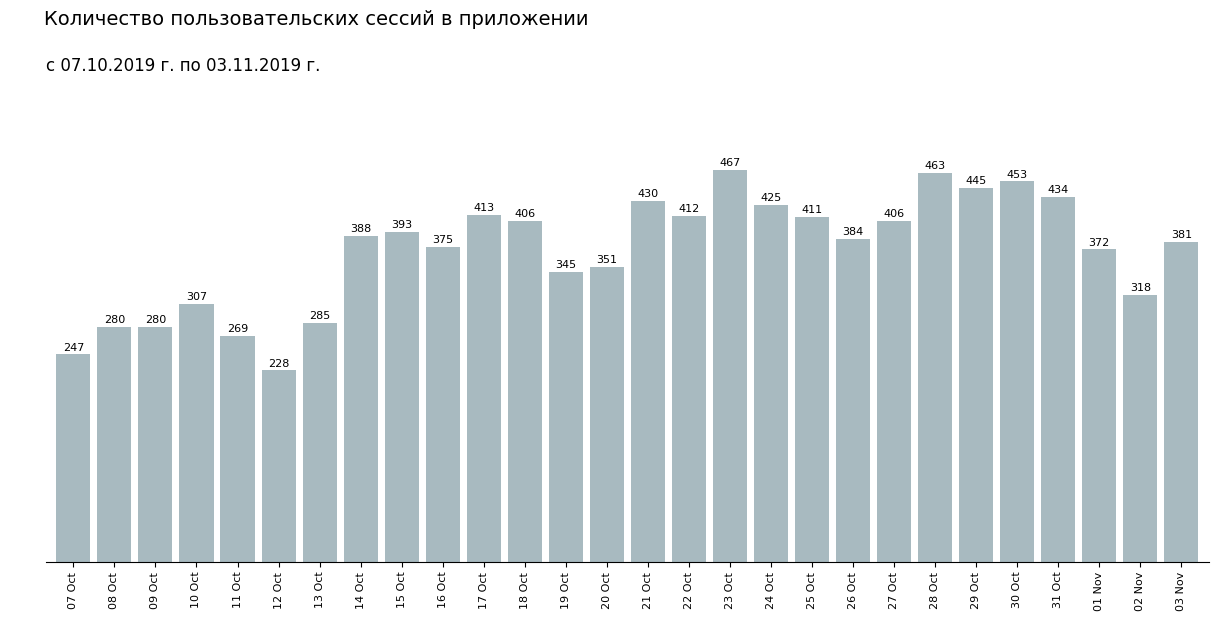

In [34]:
# построим на распределения кол-ва сессий по дням за весь период
# создадим столбец с красивым отображением дат на графиках
df['session_dt_to_chart'] = pd.to_datetime(df['session_start_dt']).dt.strftime('%d %b')
t = df.groupby(['session_start_dt', 'session_dt_to_chart'], as_index=False)['session_id'].nunique()
t = t.drop('session_start_dt', axis=1).set_index('session_dt_to_chart')
# вызовем функцию plot_bar_chart
plot_bar_chart(t, 550, 'Количество пользовательских сeccий в приложении', 1.03, 0.305, '8', 90)

In [35]:
# найдем среднее кол-ва сессий в день за представленный период
print('Среднее кол-во сессий в день: ', round(df.groupby('session_start_dt')['session_id'].nunique().mean()))

Среднее кол-во сессий в день:  370


График похож на распределние событий, также видно снижение кол-ва сессий в выходные дни, также в первую неделю кол-во сессий было меньше, чем в последующие дни. Наименьшее кол-во сессий (228), как и событий пришлось на 12 октября, наибольшее на 23 октября (467). Снижение кол-ва сессий в 1-3 ноября, связано видимо с праздниками

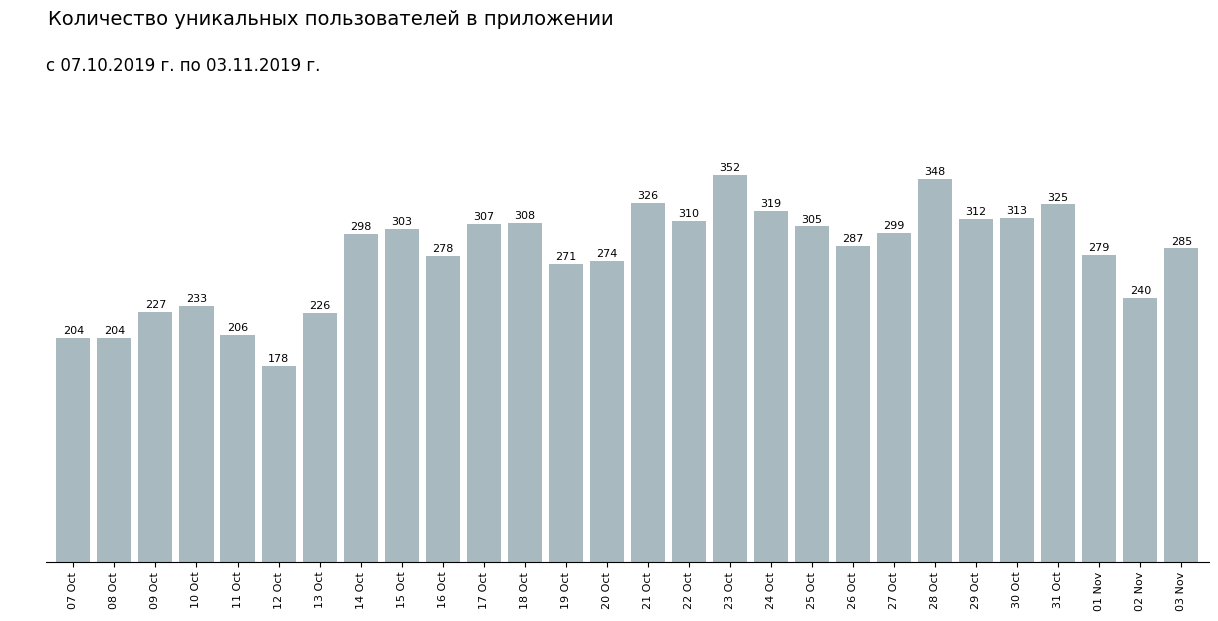

In [36]:
# построим на распределения кол-во уникальных пользователей  в день за весь период
t = df.groupby(['event_dt','dt_to_chart'], as_index=False)['user_id'].nunique()
t = t.drop('event_dt', axis=1).set_index('dt_to_chart')
# вызовем функцию plot_bar_chart
plot_bar_chart(t, 420, 'Количество уникальных пользователей в приложении', 1.03, 0.315, '8', 90)

In [37]:
# найдем среднее кол-во уникальных пользователей  в день за представленный период
print('Cреднее кол-во уникальных пользователей  в день за представленный период: ', round(df.groupby('event_dt')['user_id'].nunique().mean()))

Cреднее кол-во уникальных пользователей  в день за представленный период:  279


Распределение похожее, кол-во пользователей колебалось от 178 до 352, среднее значение 279 уникальных пользователей

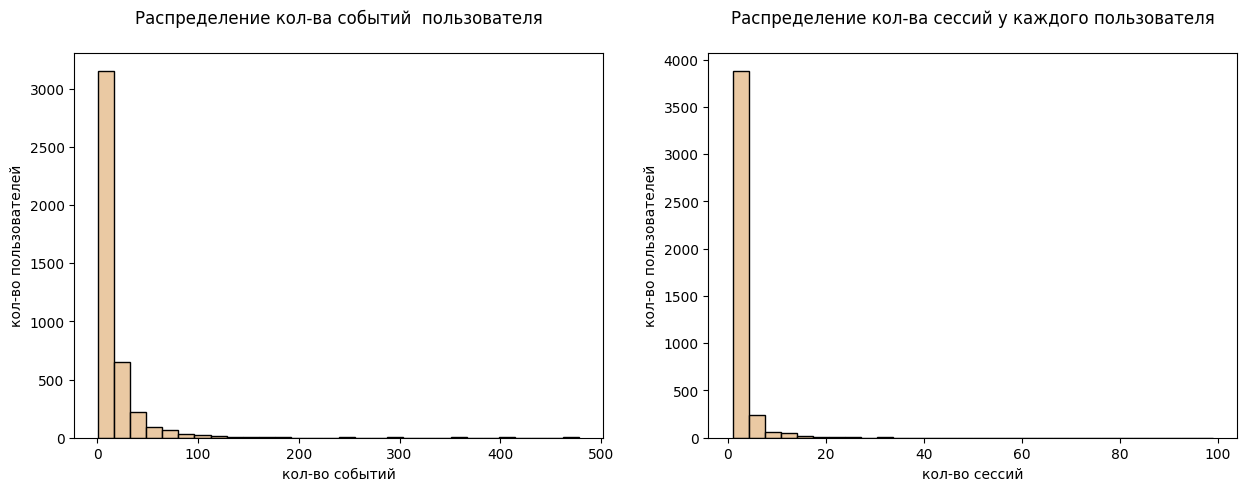

event_name   session_id
count  4293.000000  4293.000000
mean     17.283252     2.415094
std      29.130677     3.536466
min       1.000000     1.000000
25%       5.000000     1.000000
50%       9.000000     1.000000
75%      17.000000     3.000000
90%      36.000000     4.000000
95%      59.000000     7.000000
99%     132.000000    17.000000
max     478.000000    99.000000

In [38]:
# посмотрим на среднее и медианное значение кол-ва событий и сессий на каждого уникального пользователя 
# за представленный период 
t = df.groupby('user_id').agg({'event_name':'count', 'session_id': 'nunique'})
plt.figure(figsize=(15, 5))
ax1 = plt.subplot(1, 2, 1)
sns.histplot(t['event_name'], bins=30, 
             color= colors[2], alpha=0.8, ax=ax1)
plt.title('Распределение кол-ва событий  пользователя\n ')
plt.ylabel('кол-во пользователей', fontsize='10')
plt.xlabel('кол-во событий', fontsize='10')

ax2 = plt.subplot(1, 2, 2)
sns.histplot(t['session_id'], bins=30, 
             color= colors[2], alpha=0.8, ax=ax2)
plt.title('Распределение кол-ва сессий у каждого пользователя\n ')
plt.ylabel('кол-во пользователей', fontsize='10')
plt.xlabel('кол-во сессий', fontsize='10')

plt.show()

# применим метод describe
t.describe(percentiles=[.25, .75, .90, .95, .99])

Видно, что есть лояльные пользователи, которые часто пользуются приложением, но их немного, половина пользователей всего 1 раз воспользовалось приложений.  Среднее кол-во сессий на 1 уникального пользователя равна 2.4, медианна - 1 сессия. В среднем 1 пользователь совершил 17 событий, медианна составляет 9 событий

#### Распределение кол-ва пользователей, событий, сессий  в зависимости от источника
<a id="source"></a>

In [39]:
# посмотрим на кол-во сессий и уникальных пользователей, пришедших из разных источников установки
sourse = (df.groupby('source',as_index=False)
          .agg({'user_id':'nunique', 'session_id':'nunique', 'event_name': 'count'})
          .assign(avg_session_user = lambda x: round(x['session_id'] / x['user_id'], 2),
                  avg_evant_user = lambda x: round(x['event_name'] / x['user_id'], 2),
                  avg_evant_session = lambda x: round(x['event_name'] / x['session_id'], 2))
         )
sourse.sort_values(by='user_id', ascending=False)

source  user_id  session_id  event_name  avg_session_user  avg_evant_user  \
2  yandex     1934        4523       34286              2.34           17.73   
1   other     1230        3017       19466              2.45           15.83   
0  google     1129        2828       20445              2.50           18.11   

   avg_evant_session  
2               7.58  
1               6.45  
0               7.23

Большая часть пользователей имеет источник "yandex", на него же приходится и большее кол-во событий и сессий. Но если посмотреть сколько в среднем приходится сессий на 1 уникального пользователя, то поэтому значению (2.34) уступает google и другим источникам. В среднем меньше всего событий на пользователя и событий на сессию приходится на пользователей из других источников.

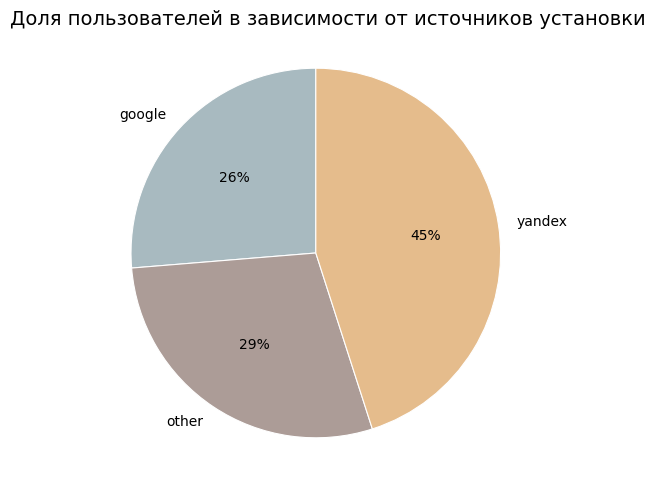

In [40]:
# посмотрим на долю пользователей по каждому источнику
plt.figure(figsize=(16, 6))
plt.suptitle('Доля пользователей в зависимости от источников установки',  fontsize=14, y=0.9, x=0.52)
plt.pie(sourse['user_id'], labels=sourse['source'],  autopct= '%1.0f%%', colors = colors,
     wedgeprops={'linewidth': 0.8, 'edgecolor': 'w'}, 
        startangle=90)
plt.show()

На источник google приходится меньше всего пользователей, но в среднем такие пользователи совершают больше событий и сессий

In [41]:
# создадим функцию для боксплотов
def box(data, col1, col2, color, i, y, ylab, titl):
    
    sns.boxplot(x= col1, y= col2, data= data, 
            color = color, ax = i)
    plt.xticks(fontsize='12', rotation=0)
    plt.xlabel('')
    plt.ylabel(ylab, fontsize='10')
    plt.ylim(0, y)
    plt.title(titl , fontsize='14')


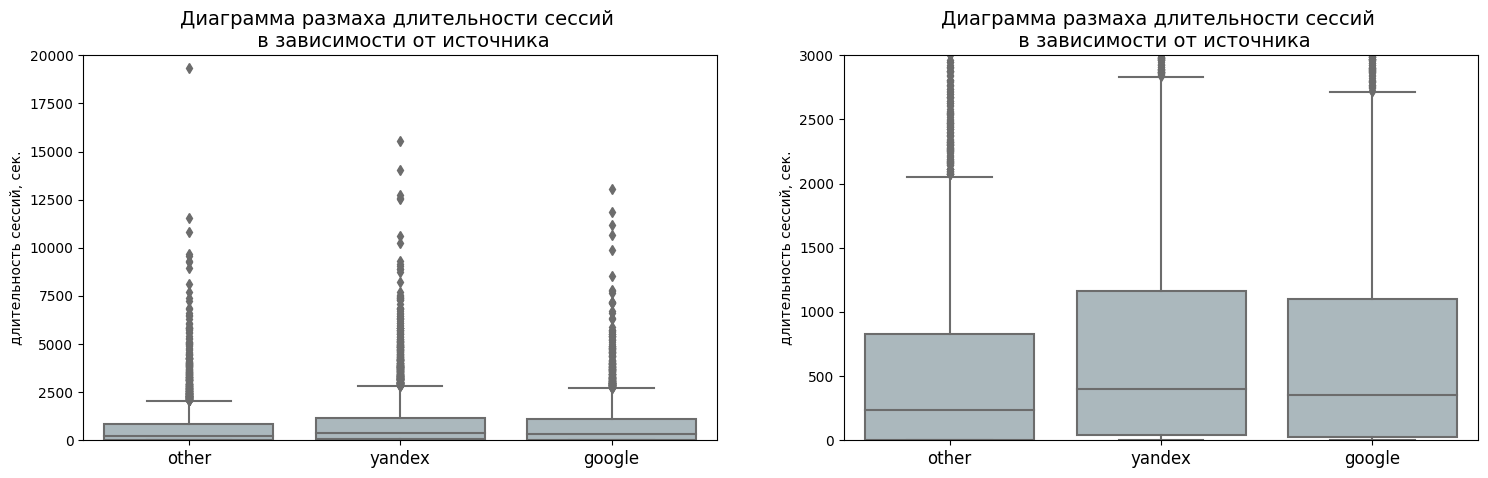

count        mean          std  min    25%    50%     75%      max
source                                                                     
google  2828.0  786.088402  1162.094036  0.0  26.75  350.0  1104.0  13049.0
other   3017.0  652.756049  1132.867216  0.0   3.00  236.0   825.0  19318.0
yandex  4523.0  843.365244  1240.965503  0.0  43.00  402.0  1160.5  15568.0

In [42]:
# посмотрим на длительность сессий у пользователей из разных источников
duration_from_source = df.groupby(['session_id', 'source'], as_index=False)['session_time'].min()

# построим боксплоты
plt.figure(figsize=(18, 5))
ax1 = plt.subplot(1, 2, 1)
box(duration_from_source, 'source', 'session_time', colors[0], ax1, 20000,
    'длительность сессий, сек.', 'Диаграмма размаха длительности сессий \n в зависимости от источника')
ax2 = plt.subplot(1, 2, 2)
box(duration_from_source, 'source', 'session_time', colors[0], ax2, 3000,
    'длительность сессий, сек.', 'Диаграмма размаха длительности сессий \n в зависимости от источника')
plt.show()

# применим метод describe
duration_from_source.groupby('source')['session_time'].describe()

У всех источников есть сессии с длительностью 0 сек и есть выбросы, меньше всего длительность сессий у источника other, больше всего (среднее - 1160.5 сек и медианна - 843 сек) у источника yandex. 

#### Распределение кол-ва пользователей, событий, сессий  в зависимости от действий
<a id="event"></a>

In [43]:
# посмотрим на сводную таблицу
event = (
    df.groupby('event_name')
      .agg({'event_name':'count', 'session_id':'nunique', 'user_id':'nunique'})
      .assign(event_rate = lambda x: round (x['event_name'] / df.shape[0] * 100, 1),
              session_rate = lambda x: round (x['session_id'] / df['session_id'].nunique() * 100, 1),
              user_rate = lambda x: round (x['user_id'] / df['user_id'].nunique() * 100, 1))
     .rename(columns={'event_name':'event_cnt', 'session_id':'session_cnt', 'user_id':'user_cnt'})
     .sort_values(by='session_rate', ascending = False)
     .reset_index()
             )
event

event_name  event_cnt  session_cnt  user_cnt  event_rate  session_rate  \
0      tips_show      40055         6035      2801        54.0          58.2   
1         search       6784         2974      1666         9.1          28.7   
2    photos_show      10012         2526      1095        13.5          24.4   
3            map       3881         2133      1456         5.2          20.6   
4  contacts_show       4529         1703       981         6.1          16.4   
5    advert_open       6164         1254       751         8.3          12.1   
6  favorites_add       1417          501       351         1.9           4.8   
7     tips_click        814          416       322         1.1           4.0   
8  contacts_call        541          312       213         0.7           3.0   

   user_rate  
0       65.2  
1       38.8  
2       25.5  
3       33.9  
4       22.9  
5       17.5  
6        8.2  
7        7.5  
8        5.0

Больше всего событий, сессий и уникальных пользователей приходится на "увидел рекомендованное объявление", а вот кликают на них редко. В 58% сессий пользователи видят рекомендованные объявления и всего в 4 % заходят в рекомендованные объявления. Целевое событие в виде просмотра контактов совершили 981 пользователей, это почти 23 %  уникальных пользователей, звонило по номеру только 5 % пользователей. Пользователи если видят полностью телефон продавца, могут сохранять номер и звонить позже, или отправлять другим людям.  
Также популярен поиск, открытие карты объявлений и просмотр фотографий

In [44]:
# функция для построения графиков
def horizontal_bar(data, col1, col2, x, n, tit):
    """Функция строит горизонтальную столбчатую диаграмму

    Args:
        data: датафрейм
        col1, col2: названия столбцов
        x: axes[x]
        tit: заголовок
        
    """
    
    axes[x].barh(data[col1], data[col2], color=colors[0], height=0.85)
    axes[x].patches[4].set_color(colors[2])
# убираем границы графика
    for s in ['top', 'bottom', 'left', 'right']:
        axes[x].spines[s].set_visible(False)
# работаем с осями
    axes[x].xaxis.set_ticks_position('none')
    axes[x].xaxis.set_tick_params(labelcolor='w')
    axes[x].set_xlim((0, n))
    axes[x].yaxis.set_tick_params(labelsize=12)
    axes[x].invert_yaxis()
    
# добавляем значения к барам
    for i in axes[x].patches:
        axes[x].text(i.get_width()+0.2, i.get_y()+0.455,
             str(round((i.get_width()), 1)),
             fontsize=10,  
             color='black')
# заголовок
    axes[x].set_title(tit, loc='left', fontsize=12, color='#35383c')

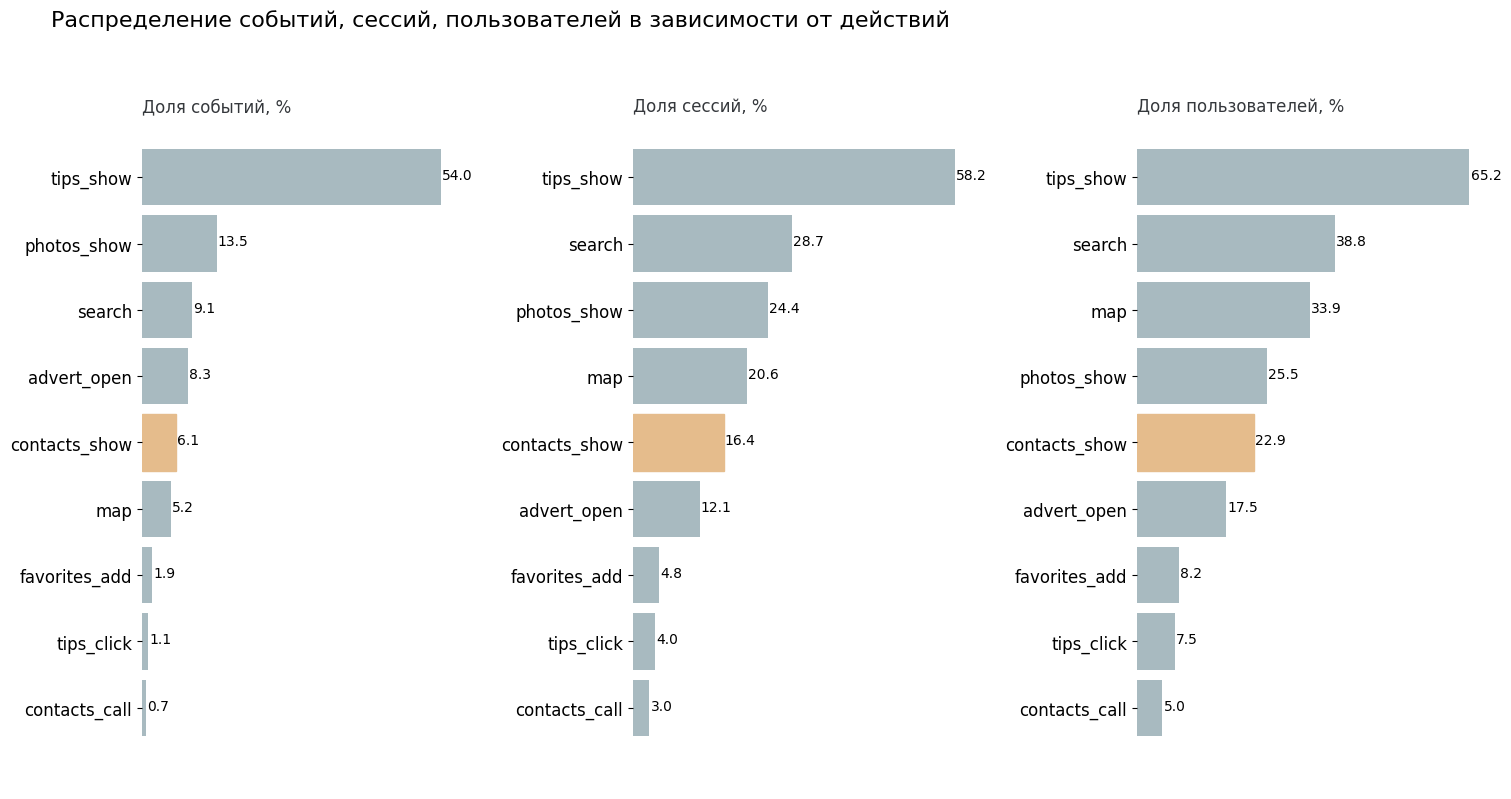

In [45]:
# построим график
fig, axes = plt.subplots(ncols=3, nrows=1, constrained_layout=True, figsize=(15, 7))
fig.suptitle('Распределение событий, сессий, пользователей в зависимости от действий',  y=1.12, x=0.33, fontsize=16)
horizontal_bar(event.sort_values(by='event_rate', ascending=False), 
               'event_name', 'event_rate', 0, 60, 'Доля событий, %')
horizontal_bar(event, 'event_name', 'session_rate', 1, 60, 'Доля сессий, %')
horizontal_bar(event.sort_values(by='user_rate', ascending=False), 
               'event_name', 'user_rate', 2, 65, 'Доля пользователей, %')

Просмотр контактов везде на 5 месте. Пользователи чаще смотрят рекомендации, чем используют поиск и карту объявлений. 

#### Распределение кол-ва пользователей, событий, сессий  в зависимости от  совершения целевого события
<a id="target"></a>


In [46]:
# посмотрим на кол-во и долю уникальных пользователей по дням в разрезе целевого события
target_users = (df
    .pivot_table(index=['event_dt', 'dt_to_chart'], columns= ['target_user_day'], 
                 values='user_id', aggfunc='nunique')
    .reset_index()
    .drop('event_dt', axis=1)
    .rename(columns={1: 'cnt_target_user', 0: 'cnt_no_target_user'})
    .assign(rate_target_users = lambda x: round(x['cnt_target_user'] / 
            (x['cnt_no_target_user'] + x['cnt_target_user']) * 100, 2))
)
target_users.T

0       1       2       3       4       5       6   \
target_user_day                                                              
dt_to_chart         07 Oct  08 Oct  09 Oct  10 Oct  11 Oct  12 Oct  13 Oct   
cnt_no_target_user     170     168     186     189     172     151     192   
cnt_target_user         34      36      41      44      34      27      34   
rate_target_users    16.67   17.65   18.06   18.88    16.5   15.17   15.04   

                        7       8       9       10      11      12      13  \
target_user_day                                                              
dt_to_chart         14 Oct  15 Oct  16 Oct  17 Oct  18 Oct  19 Oct  20 Oct   
cnt_no_target_user     248     246     237     245     242     226     220   
cnt_target_user         50      57      41      62      66      45      54   
rate_target_users    16.78   18.81   14.75    20.2   21.43   16.61   19.71   

                        14      15      16      17      18      19      20  \
target_user_day                                                              
dt_to_chart         21 Oct  22 Oct  23 Oct  24 Oct  25 Oct  26 Oct  27 Oct   
cnt_no_target_user     269     242     284     256     245     236     252   
cnt_target_user         57      68      68      63      60      51      47   
rate_target_users    17.48   21.94   19.32   19.75   19.67   17.77   15.72   

                        21      22      23      24      25      26      27  
target_user_day                                                             
dt_to_chart         28 Oct  29 Oct  30 Oct  31 Oct  01 Nov  02 Nov  03 Nov  
cnt_no_target_user     289     258     255     263     216     190     226  
cnt_target_user         59      54      58      62      63      50      59  
rate_target_users    16.95   17.31   18.53   19.08   22.58   20.83    20.7

In [47]:
# посмотрим на кол-во и долю сессий по дням в разрезе целевого события
target_sessions = (df
    .pivot_table(index=['session_start_dt', 'session_dt_to_chart'], columns= ['target_session'], 
                 values='session_id', aggfunc='nunique')
    .reset_index()
    .drop('session_start_dt', axis=1)
    .rename(columns={1: 'cnt_target_session', 0: 'cnt_no_target_session'})
    .assign(rate_target_sessions = lambda x: round(x['cnt_target_session'] / 
                                                  (x['cnt_no_target_session'] + x['cnt_target_session']) * 100, 2))
)
target_sessions.T

0       1       2       3       4       5       6   \
target_session                                                                  
session_dt_to_chart    07 Oct  08 Oct  09 Oct  10 Oct  11 Oct  12 Oct  13 Oct   
cnt_no_target_session     210     240     236     258     231     199     250   
cnt_target_session         37      40      44      49      38      29      35   
rate_target_sessions    14.98   14.29   15.71   15.96   14.13   12.72   12.28   

                           7       8       9       10      11      12      13  \
target_session                                                                  
session_dt_to_chart    14 Oct  15 Oct  16 Oct  17 Oct  18 Oct  19 Oct  20 Oct   
cnt_no_target_session     331     329     326     340     328     297     285   
cnt_target_session         57      64      49      73      78      48      66   
rate_target_sessions    14.69   16.28   13.07   17.68   19.21   13.91    18.8   

                           14      15      16      17      18      19      20  \
target_session                                                                  
session_dt_to_chart    21 Oct  22 Oct  23 Oct  24 Oct  25 Oct  26 Oct  27 Oct   
cnt_no_target_session     360     326     387     350     342     323     355   
cnt_target_session         70      86      80      75      69      61      51   
rate_target_sessions    16.28   20.87   17.13   17.65   16.79   15.89   12.56   

                           21      22      23      24      25      26      27  
target_session                                                                 
session_dt_to_chart    28 Oct  29 Oct  30 Oct  31 Oct  01 Nov  02 Nov  03 Nov  
cnt_no_target_session     394     370     374     358     300     257     309  
cnt_target_session         69      75      79      76      72      61      72  
rate_target_sessions     14.9   16.85   17.44   17.51   19.35   19.18    18.9

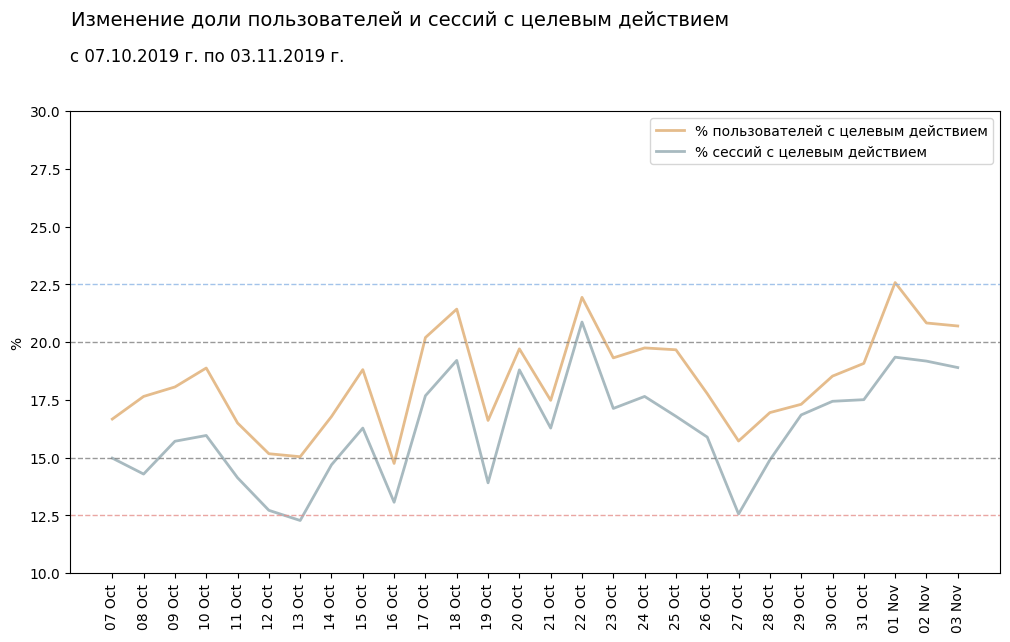

In [48]:
# построим график 
plt.figure(figsize=(12, 6))
plt.plot(target_users['dt_to_chart'], target_users['rate_target_users'], 
         color=colors[2], linewidth=2, label='% пользователей с целевым действием')
plt.plot(target_sessions['session_dt_to_chart'], target_sessions['rate_target_sessions'], 
         color=colors[0], linewidth=2, label ='% сессий с целевым действием')
plt.legend(fontsize=10)
plt.xticks(color='black', fontsize='10', rotation = 90)
plt.xlabel('')
plt.ylabel('%', fontsize='10')  
plt.yticks(color='black', fontsize='10')
plt.ylim(10,30)
plt.axhline(y=20, color='grey', alpha=0.8, linestyle='--', linewidth=1.0)
plt.axhline(y=15, color='grey', alpha=0.8, linestyle='--', linewidth=1.0)
plt.axhline(y=12.5, color='#e5908c', alpha=0.8, linestyle='--', linewidth=1.0)
plt.axhline(y=22.5, color='#8cb5e5', alpha=0.8, linestyle='--', linewidth=1.0)
plt.suptitle('Изменение доли пользователей и сессий с целевым действием', y=1.05, x=0.4,  fontsize=14)
plt.title('с 07.10.2019 г. по 03.11.2019 г. \n \n ', fontsize='12', loc='left')
plt.show();

Доля пользователей на всем периоде выше доли сессий. Динамика изменений по дням схожа. Заметны колебания от 15 до 22,5% у долей поьзователей и от 12,5 до 21% у доли сессий с просмотров контактов. За первые дни ноября доля пользователей не опускалась ниже 20%, хотя и кол-во пользователей в эти дни за счет праздников было меньше. Интересно, что на 23 октября, когда наблюдалось максимальное кол-во событий, сессий и пользователей, доля пользователей и сессий с целевым событием не была на максимальных показателях.  

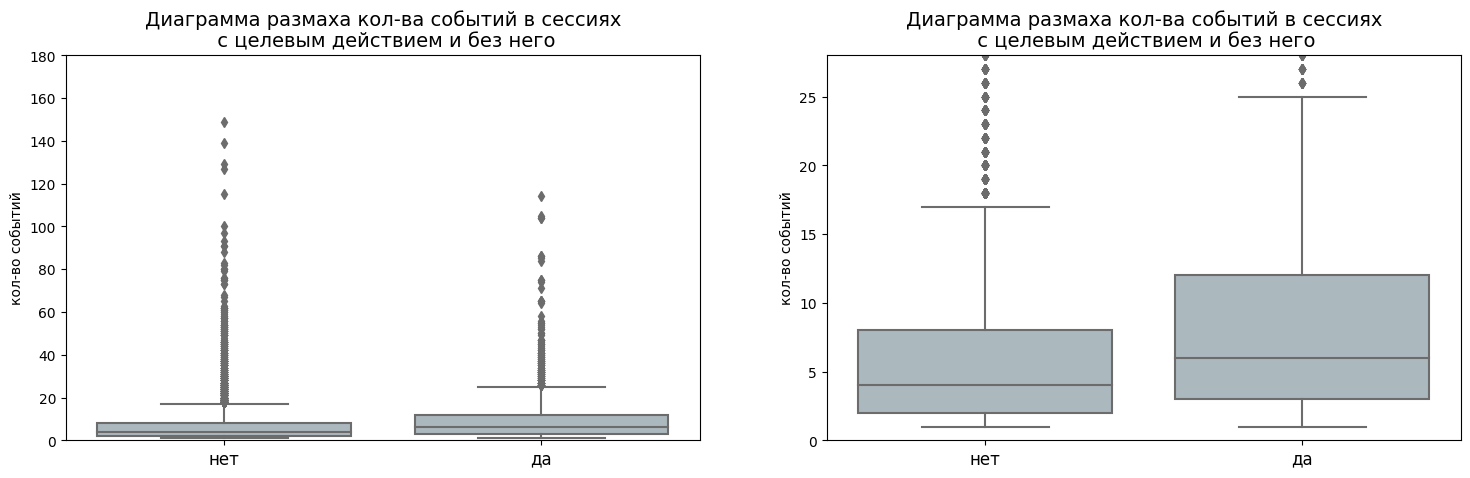

count      mean        std  min  25%  50%   75%    max
target_session                                                         
да              1703.0  9.871991  11.797351  1.0  3.0  6.0  12.0  114.0
нет             8665.0  6.622620   8.986999  1.0  2.0  4.0   8.0  149.0

In [49]:
# посмотрим на кол-во событий в сессиях с целевым действием и без него 
target_event_cnt = df.groupby(['session_id', 'target_session'], as_index=False)['event_name'].count()
target_event_cnt['target_session'] = target_event_cnt['target_session'].map({0:'нет', 1:'да'})

# построим боксплоты
plt.figure(figsize=(18, 5))
ax1 = plt.subplot(1, 2, 1)
box(target_event_cnt, 'target_session', 'event_name', colors[0], ax1, 180,
    'кол-во событий', 'Диаграмма размаха кол-ва событий в сессиях\n с целевым действием и без него')

ax2 = plt.subplot(1, 2, 2)
box(target_event_cnt, 'target_session', 'event_name', colors[0], ax2, 28,
    'кол-во событий', 'Диаграмма размаха кол-ва событий в сессиях\n с целевым действием и без него')
plt.show()

# применим метод describe
target_event_cnt.groupby('target_session')['event_name'].describe()

В сессиях с просмотром контактов происходит больше событий. Медианна равна  6, в сессиях без просмотра контактов равна 4. 

In [50]:
# создадим функцию для боксплотов c параметром hue
def box_hue(data, col1, col2, col3, color, i, y, ylab, titl):
    
    sns.boxplot(x= col1, y= col2, data= data, hue=col3,
            palette = color, ax = i)
    plt.xticks(fontsize='10', rotation=0)
    plt.xlabel('')
    plt.ylabel(ylab, fontsize='8')
    plt.ylim(0, y)
    plt.legend(loc='upper right')
    plt.title(titl , fontsize='12')

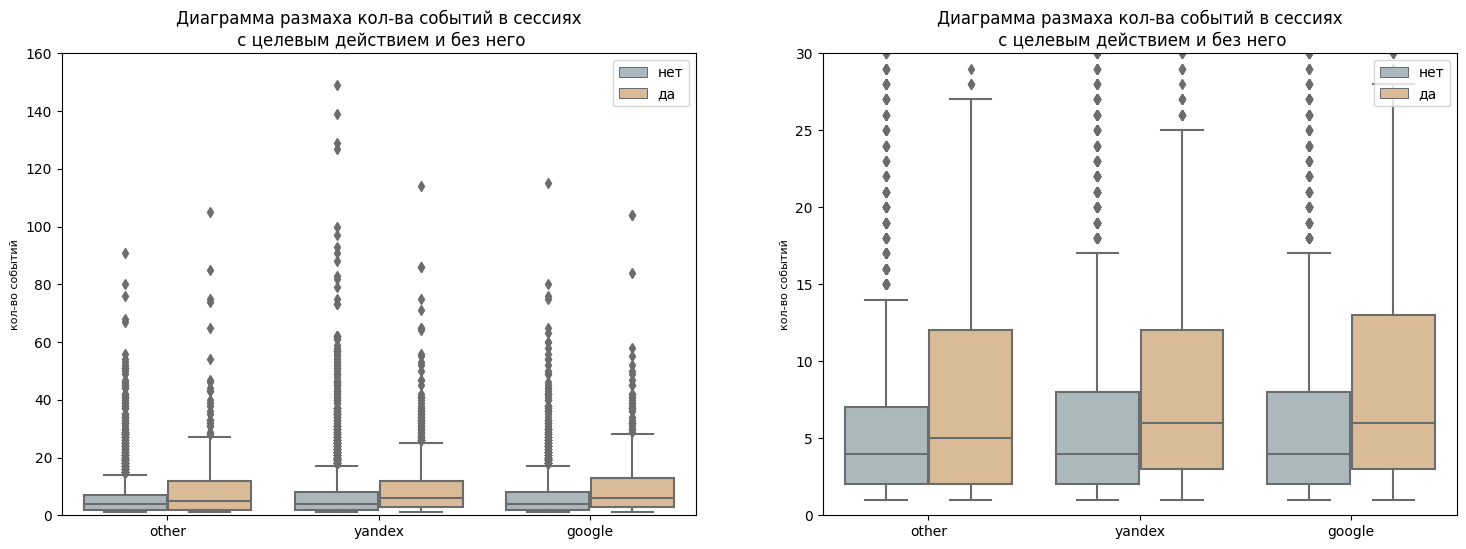

count       mean        std  min  25%  50%   75%  \
source target_session                                                      
google да               527.0  10.326376  11.833273  1.0  3.0  6.0  13.0   
       нет             2301.0   6.520209   8.424816  1.0  2.0  4.0   8.0   
other  да               409.0   9.293399  12.059574  1.0  2.0  5.0  12.0   
       нет             2608.0   6.006518   7.735087  1.0  2.0  4.0   7.0   
yandex да               767.0   9.868318  11.632072  1.0  3.0  6.0  12.0   
       нет             3756.0   7.113152  10.041338  1.0  2.0  4.0   8.0   

                         max  
source target_session         
google да              104.0  
       нет             115.0  
other  да              105.0  
       нет              91.0  
yandex да              114.0  
       нет             149.0

In [51]:
# посмотрим на кол-во событий в сессиях с целевым событием  у пользователей из разных источников 
target_source_event_cnt = df.groupby(['session_id', 'target_session', 'source'], as_index=False)['event_name'].count()
target_source_event_cnt['target_session'] = target_source_event_cnt['target_session'].map({0:'нет', 1:'да'})

# построим боксплоты
plt.figure(figsize=(18, 6))
ax1 = plt.subplot(1, 2, 1)
box_hue(target_source_event_cnt, 'source', 'event_name','target_session', [colors[0], colors[2]], ax1, 160,
    'кол-во событий', 'Диаграмма размаха кол-ва событий в сессиях\n с целевым действием и без него')

ax2 = plt.subplot(1, 2, 2)
box_hue(target_source_event_cnt, 'source', 'event_name','target_session', [colors[0], colors[2]], ax2, 30,
    'кол-во событий', 'Диаграмма размаха кол-ва событий в сессиях\n с целевым действием и без него')

plt.show()

# применим метод describe
target_source_event_cnt.groupby(['source','target_session'])['event_name'].describe()

В сессиях с целевым действием , независмо от источника установки, происходит больше событий.Больше всего событий у пользователей из источника google

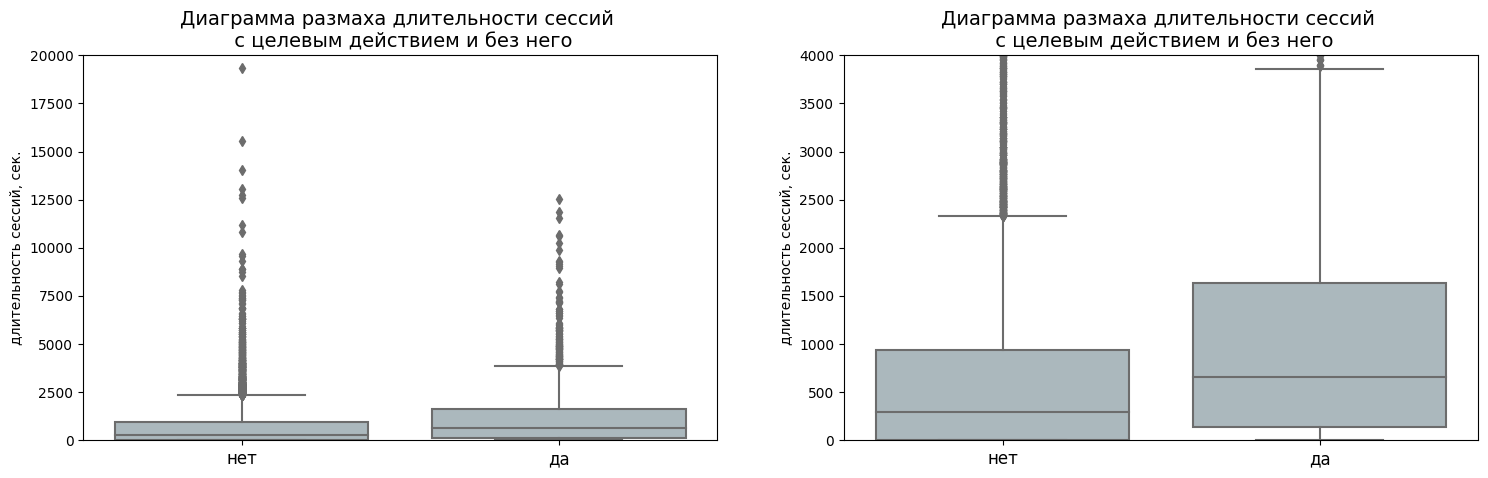

count         mean          std  min    25%    50%     75%  \
target_session                                                                
да              1703.0  1206.604228  1591.877390  0.0  141.0  654.0  1629.5   
нет             8665.0   686.914830  1075.487812  0.0    6.0  292.0   935.0   

                    max  
target_session           
да              12545.0  
нет             19318.0

In [52]:
# посмотрим на длительность сессий с целевым действием и без него 
target_session_time = df.groupby(['session_id', 'target_session'], as_index=False)['session_time'].min()
target_session_time['target_session'] = target_session_time['target_session'].map({0:'нет', 1:'да'})

# построим боксплоты
plt.figure(figsize=(18, 5))
ax1 = plt.subplot(1, 2, 1)
box(target_session_time, 'target_session', 'session_time', colors[0], ax1, 20000,
    'длительность сессий, сек.', 'Диаграмма размаха длительности сессий \n с целевым действием и без него')

ax2 = plt.subplot(1, 2, 2)
box(target_session_time, 'target_session', 'session_time', colors[0], ax2, 4000,
    'длительность сессий, сек.', 'Диаграмма размаха длительности сессий \n с целевым действием и без него')
plt.show()

# применим метод describe
target_session_time.groupby('target_session')['session_time'].describe()

В сессиях с целевым событием и больше длительность, медианна равна 654 сек, почти 11 мин. Что больше, чем в 2 раза длительности сессий без просмотра контактов.

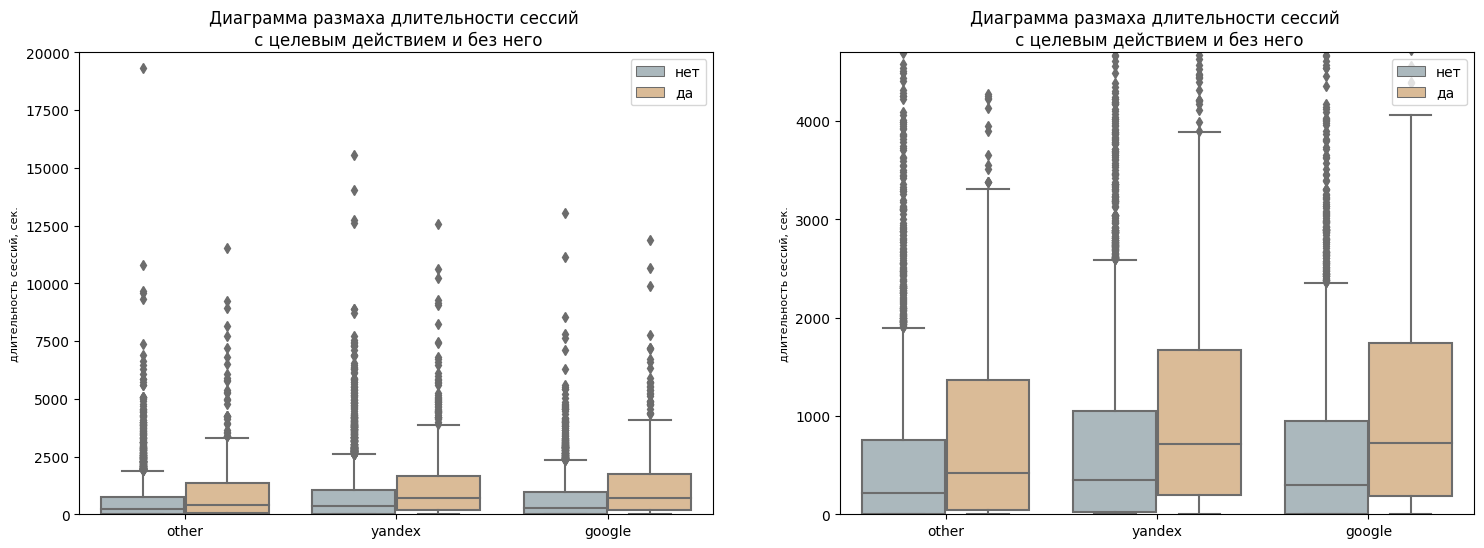

count         mean          std  min     25%    50%  \
source target_session                                                         
google да               527.0  1295.770398  1613.000212  0.0  182.00  721.0   
       нет             2301.0   669.355498   995.854499  0.0    4.00  293.0   
other  да               409.0  1048.400978  1593.058184  0.0   45.00  420.0   
       нет             2608.0   590.708972  1029.149196  0.0    0.00  215.0   
yandex да               767.0  1229.700130  1572.524524  0.0  194.00  713.0   
       нет             3756.0   764.473110  1146.036207  0.0   22.75  350.0   

                           75%      max  
source target_session                    
google да              1741.00  11878.0  
       нет              945.00  13049.0  
other  да              1367.00  11543.0  
       нет              758.50  19318.0  
yandex да              1676.00  12545.0  
       нет             1050.25  15568.0

In [53]:
# посмотрим на длительность сессий с целевым действием и без него у пользователей из разных источников 
target_source_session_time = df.groupby(['session_id', 'target_session', 'source'], as_index=False)\
                                        ['session_time'].min()
target_source_session_time['target_session'] = target_source_session_time['target_session'].map({0:'нет', 1:'да'})

# построим боксплоты
plt.figure(figsize=(18, 6))
ax1 = plt.subplot(1, 2, 1)
box_hue(target_source_session_time, 'source', 'session_time', 'target_session', [colors[0], colors[2]], ax1, 20000,
     'длительность сессий, сек.', 'Диаграмма размаха длительности сессий \n с целевым действием и без него')

ax2 = plt.subplot(1, 2, 2)
box_hue(target_source_session_time, 'source', 'session_time', 'target_session', [colors[0], colors[2]], ax2, 4700,
     'длительность сессий, сек.', 'Диаграмма размаха длительности сессий \n с целевым действием и без него')


plt.show()

# применим метод describe
target_source_session_time.groupby(['source','target_session'])['session_time'].describe()

**Вывод:** 
- среднее значение кол-ва событий в день за весь период составляет -  2650
- среднее кол-во сессий в день - 370
- среднее кол-во уникальных пользователей - 279
- отмечается снижение активности пользователей в выходные дни
- в последние неделю особого роста активности не наблюдалось
- с 1 по 3 ноября заметен некоторый спад, что связано с выходными и праздничными днями
- большая часть пользователей имеет источник yandex - 45%, меньше всего пользователей из google - 26 %
- на yandex приходится и самое большое кол-во событий и сессий
- взависимости от источника длительность сессии варьируется, выше показания у google и yandex, а вот из other источников медианна ниже, чем медиана по длительности всех сессии
- кол-во событий в сессиях и длительность сессий выше в сессиях с целевым действием, чем  без целевого действия.
- длительность сессий с целевым событием из источника other заметно ниже, чем у таких сессий из других источников 
- доля целевых событий - 6.1% , доля целевых сессий - 16.4%
- большую долю(более 50%) занимают события и сессии с tips_show

##  Анализ поведения пользователей
<a id="objective"></a>

#### Анализ связи целевого события —просмотра контактов — и других действий пользователей
<a id="objective1"></a>

In [54]:
# подготовим данные,  удалим повторяющие действия, идущие подряд
df_sankey = (df.sort_values(by= ['session_id', 'event_time'])
             .assign(count=np.nan)
             .groupby(df['event_name'].ne(df['event_name'].shift()).cumsum(), as_index=False)
             .agg({'session_id': 'first', 'event_time': 'first', 'event_name': 'first',  'count': 'size'})
             .sort_values(by=['session_id', 'event_time'])
            )
df_sankey.head(10)

session_id                 event_time event_name  count
0           1 2019-10-07 13:39:45.989359  tips_show      9
1           2 2019-10-09 18:33:55.577963        map      2
2           2 2019-10-09 18:40:28.738785  tips_show      4
3           3 2019-10-21 19:53:38.767230        map      1
4           3 2019-10-21 19:54:45.009859  tips_show      2
5           3 2019-10-21 19:56:49.417415        map      1
6           3 2019-10-21 19:57:21.124551  tips_show      8
7           4 2019-10-22 11:18:14.635436        map      1
8           4 2019-10-22 11:19:10.529462  tips_show      3
9           4 2019-10-22 11:25:33.508919        map      1

Видны теперь чередующие повторяющие действия, тогда будем удалять дубликаты в сессиях и оставлять первое вхождение

In [55]:
# сортируем по session_id и времени, удаляем дубликаты
df_event_path = (df
             .sort_values(by=['session_id', 'event_time'])
             .drop_duplicates(subset=['session_id', 'event_name'], keep='first')
            )
df_sankey = df_event_path.copy()
# добавляем шаги событий
df_sankey['step'] = df_sankey.groupby('session_id').cumcount() + 1
    
# добавляем узлы-источники и целевые узлы
# узлы-источники - это сами события
df_sankey['source'] = df_sankey['event_name']
# добавляем целевые узлы
df_sankey['target'] = df_sankey.groupby('session_id')['source'].shift(-1)
df_sankey = df_sankey[['event_time', 'session_id', 'source', 'target', 'step']]
df_sankey.head()

event_time  session_id     source     target  step
805   2019-10-07 13:39:45.989359           1  tips_show        NaN     1
6541  2019-10-09 18:33:55.577963           2        map  tips_show     1
6565  2019-10-09 18:40:28.738785           2  tips_show        NaN     2
36412 2019-10-21 19:52:30.778932           3  tips_show        map     1
36419 2019-10-21 19:53:38.767230           3        map        NaN     2

Далее создаем функции, для диаграммы Sankey

In [56]:
def get_source_index(df):
    
    """Функция генерации индексов source

    Args:
        df (pd.DataFrame): исходная таблица с признаками step, source, target.
    Returns:
        dict: словарь с индексами, именами и соответсвиями индексов именам source.
    """
    
    res_dict = {}
    
    count = 0
    # получаем индексы источников
    for no, step in enumerate(df['step'].unique().tolist()):
        # получаем уникальные наименования для шага
        res_dict[no+1] = {}
        res_dict[no+1]['sources'] = df[df['step'] == step]['source'].unique().tolist()
        res_dict[no+1]['sources_index'] = []
        for i in range(len(res_dict[no+1]['sources'])):
            res_dict[no+1]['sources_index'].append(count)
            count += 1
            
    # соединим списки
    for key in res_dict:
        res_dict[key]['sources_dict'] = {}
        for name, no in zip(res_dict[key]['sources'], res_dict[key]['sources_index']):
            res_dict[key]['sources_dict'][name] = no
    return res_dict

In [57]:
source_indexes = get_source_index(df_sankey)

In [58]:
def colors_for_sources(mode):
    
    """Генерация цветов rgba

    Args:
        mode (str): сгенерировать случайные цвета, если 'random', а если 'custom' - 
                    использовать заранее подготовленные
    Returns:
        dict: словарь с цветами, соответствующими каждому индексу
    """
    # словарь, в который сложим цвета в соответствии с индексом
    colors_dict = {}
    
    if mode == 'random':
        # генерим случайные цвета
        for label in df_sankey['source'].unique():
            r, g, b = np.random.randint(255, size=3)            
            colors_dict[label] = f'rgba({r}, {g}, {b}, 1)'
            
    elif mode == 'custom':
        # присваиваем ранее подготовленные цвета
        colors = {"custom_colors": ["rgba(42, 157, 143, 1)", "rgba(38, 70, 83, 1)", "rgba(233, 196, 106, 1)", "rgba(244, 162, 97, 1)", \
                                    "rgba(231, 111, 81, 1)", "rgba(230, 57, 70, 1)", "rgba(168, 218, 220, 1)", "rgba(69, 123, 157, 1)", \
                                    "rgba(29, 53, 87, 1)", "rgba(107, 112, 92, 1)", "rgba(183, 183, 164, 1)", "rgba(221, 190, 169, 1)",\
                                    "rgba(142, 202, 230, 1)", "rgba(33, 158, 188, 1)", "rgba(2, 48, 71, 1)", "rgba(255, 183, 3, 1)",\
                                    "rgba(251, 133, 0, 1)", "rgba(153, 217, 140, 1)", "rgba(118, 200, 147, 1)", "rgba(52, 160, 164, 1)", \
                                    "rgba(26, 117, 159, 1)", "rgba(247, 37, 133, 1)", "rgba(181, 23, 158, 1)", "rgba(114, 9, 183, 1)", \
                                    "rgba(86, 11, 173, 1)", "rgba(72, 149, 239, 1)", "rgba(76, 201, 240, 1)", "rgba(242, 132, 130, 1)", \
                                    "rgba(132, 165, 157, 1)", "rgba(246, 189, 96, 1)", "rgba(187, 62, 3, 1)", "rgba(204, 213, 174, 1)", \
                                    "rgba(233, 237, 201, 1)", "rgba(254, 250, 224, 1)", "rgba(212, 163, 115, 1)", "rgba(96, 108, 56, 1)", \
                                    "rgba(40, 54, 24, 1)", "rgba(249, 199, 79, 1)", "rgba(144, 190, 109, 1)", "rgba(67, 170, 139, 1)", \
                                    "rgba(77, 144, 142, 1)", "rgba(87, 117, 144, 1)", "rgba(39, 125, 161, 1)", "rgba(239, 71, 111, 1)", \
                                    "rgba(255, 209, 102, 1)", "rgba(6, 214, 160, 1)", "rgba(17, 138, 178, 1)", "rgba(7, 59, 76, 1)", \
                                    "rgba(0, 53, 102, 1)", "rgba(226, 175, 255, 1)", "rgba(248, 173, 157, 1)", "rgba(211, 211, 211, 1)", \
                                    "rgba(254, 228, 64, 1)", "rgba(241, 91, 181, 1)", "rgba(155, 93, 229, 1)", "rgba(0, 187, 249, 1)",\
                                    "rgba(0, 245, 212, 1)", "rgba(130, 192, 204, 1)", "rgba(128, 185, 24, 1)", "rgba(43, 147, 72, 1)"]}
       

        for no, label in enumerate(df_sankey['source'].unique()):
            colors_dict[label] = colors['custom_colors'][no]
            
    return colors_dict

In [59]:
colors_dict = colors_for_sources(mode='custom')

In [60]:
# пересчитаем количестов cессий в процентах от входа
def percent_sessions(sources, targets, values):
    
    """
    Расчет уникальных id в процентах (для вывода в hover text каждого узла)
    
    Args:
        sources (list): список с индексами source.
        targets (list): список с индексами target.
        values (list): список с "объемами" потоков.
        
    Returns:
        list: список с "объемами" потоков в процентах
    """
    
    # объединим источники и метки и найдем пары
    zip_lists = list(zip(sources, targets, values))
    
    new_list = []
    
    # подготовим список словарь с общим объемом трафика в узлах
    unique_dict = {}
    
    # проходим по каждому узлу
    for source, target, value in zip_lists:
        if source not in unique_dict:
            # находим все источники и считаем общий трафик
            unique_dict[source] = 0
            for sr, tg, vl in zip_lists:
                if sr == source:
                    unique_dict[source] += vl
                    
    # считаем проценты
    for source, target, value in zip_lists:
        new_list.append(round(100 * value / unique_dict[source], 1))
    
    return new_list

In [61]:
def lists_for_plot(source_indexes=source_indexes, colors=colors_dict, frac=10):
    
    """
    Создаем необходимые для отрисовки диаграммы переменные списков 
    
    Args:
        source_indexes (dict): словарь с именами и индексами source.
        colors (dict): словарь с цветами source.
        frac (int): ограничение на минимальный "объем" между узлами.
        
    Returns:
        dict: словарь со списками, необходимыми для диаграммы.
    """
    
    sources = []
    targets = []
    values = []
    labels = []
    link_color = []
    link_text = []

    # проходим по каждому шагу
    for step in tqdm(sorted(df_sankey['step'].unique()), desc='Шаг'):
        if step + 1 not in source_indexes:
            continue

        # получаем индекс источника
        temp_dict_source = source_indexes[step]['sources_dict']

        # получаем индексы цели
        temp_dict_target = source_indexes[step+1]['sources_dict']

        # проходим по каждой возможной паре, считаем количество таких пар
        for source, index_source in tqdm(temp_dict_source.items()):
            for target, index_target in temp_dict_target.items():
                # делаем срез данных и считаем количество id            
                temp_df = df_sankey[(df_sankey['step'] == step)&(df_sankey['source'] == source)&
                                    (df_sankey['target'] == target)]
                value = len(temp_df)
                # проверяем минимальный объем потока и добавляем нужные данные
                if value > frac:
                    sources.append(index_source)
                    targets.append(index_target)
                    values.append(value)
                    # делаем поток прозрачным для лучшего отображения
                    link_color.append(colors[source].replace(', 1)', ', 0.2)'))
                    
    labels = []
    colors_labels = []
    for key in source_indexes:
        for name in source_indexes[key]['sources']:
            labels.append(name)
            colors_labels.append(colors[name])
            
    # посчитаем проценты всех потоков
    perc_values = percent_sessions(sources, targets, values)
    
    # добавим значения процентов для howertext
    link_text = []
    for perc in perc_values:
        link_text.append(f"{perc}%")
        
    # возвратим словарь с вложенными списками
    return {'sources': sources, 
            'targets': targets, 
            'values': values, 
            'labels': labels, 
            'colors_labels': colors_labels, 
            'link_color': link_color, 
            'link_text': link_text}

In [62]:
data_for_plot = lists_for_plot()

Шаг:   0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

In [63]:
def plot_senkey_diagram(data_dict=data_for_plot):    
    
    """
    Функция для генерации объекта диаграммы Сенкей 
    
    Args:
        data_dict (dict): словарь со списками данных для построения.
        
    Returns:
        plotly.graph_objs._figure.Figure: объект изображения.
    """
    
    fig = go.Figure(data=[go.Sankey(
        domain = dict(
          x =  [0,1],
          y =  [0,1]
        ),
        orientation = "h",
        valueformat = ".0f",
        node = dict(
          pad = 50,
          thickness = 15,
          line = dict(color = "black", width = 0.1),
          label = data_dict['labels'],
          color = data_dict['colors_labels']
        ),
        link = dict(
          source = data_dict['sources'], # indices correspond to labels, eg A1, A2, A1, B1, ...
          target = data_dict['targets'],
          value = data_dict['values'],
          label = data_dict['link_text'],
          color = data_dict['link_color']
      ))])
    fig.update_layout(title_text="Взаимосвязи действий пользователей ", font_size=12, width=1000, height=600)
    
    # возвращаем объект диаграммы
    return fig

In [64]:
senkey_diagram = plot_senkey_diagram()
senkey_diagram.show("notebook")

![](https://github.com/KristinaChu/picture/blob/main/sankey1.png?raw=true)

Видно, что больше всего превым действием в сессиях пользователь используют поиск, так же активно просматривают рекомендованные объявления и смотрят карту объявлений. Большая часть сессий имеют ход просмотр карты → просмотр рекомендаций. Те, кто начали свою сессию с поиска, далее чаще всего или просматривают фотографии или рекомендованные объявления. Те кто, начал с просмотра рекомендаций, чаще  всего далее просматривают контакты пользователей, меньше переходят к карте объявлений или совершают клики по рекомендациям.

In [65]:
# создадим таблицу где для каждой сессии будет выводиться путь действий
df_event_path = (
                 df_event_path
                 .sort_values(by=['session_id', 'event_time'])\
                 .groupby('session_id')['event_name']
                 .apply(list).reset_index()
                 .rename(columns={'event_name': 'event_path'})
) 

display(df_event_path.head())

# всего сценариев сессий
print('Кол-во различных сценариев: ', df_event_path['event_path'].astype('str').nunique())

session_id             event_path
0           1            [tips_show]
1           2       [map, tips_show]
2           3       [tips_show, map]
3           4       [map, tips_show]
4           5  [search, photos_show]

Кол-во различных сценариев:  380


In [66]:
# посмотрим на кол-во каждого пути, выведем 10 самых популярных
( 
    df_event_path['event_path']
        .value_counts()
        .to_frame()
        .assign(rate = lambda x: round(x / df['session_id'].nunique() * 100, 1))
        .head()
)   

event_path  rate
[tips_show]                  2677  25.8
[photos_show]                1320  12.7
[search]                      762   7.3
[map, tips_show]              547   5.3
[search, photos_show]         524   5.1

Сценариев действий большое кол-во. В 10-ке самых популярных сценариев можно видеть 2 сценария с просмотром контактов: tips_show → contacts_show - 342 сессии  и просто contacts_show - 195.   
Больше всего сессий (25,8%) пользователи смотрят только рекомендованные объявления. Таким образом пользователям удобно пролистывать рекомендации для поиска товара и чаще всего такое пролистывание приводит к целевому действию

In [67]:
# посмотрим на пути с contacts_show, выведем общее кол-во и кол-во по каждому сценарию
event_path_target = df_event_path[df_event_path['event_path'].astype('str').str.contains('contacts_show')]

print('Кол-во различных сценариев с просмотром контактов: ', event_path_target['event_path'].astype('str').nunique())
display(event_path_target['event_path'].value_counts().to_frame().head())

Кол-во различных сценариев с просмотром контактов:  197


event_path
[tips_show, contacts_show]              342
[contacts_show]                         195
[contacts_show, contacts_call]          120
[map, tips_show, contacts_show]          94
[photos_show, contacts_show]             85

Сценариев, где  пользователи через первое событие tips_show, вторым совершают - contacts_show значительно больше, чем когда к просмотру контактов приходят через поиск или просмотра карт объявлений.
Четкого сценария для построения воронки не видно.   
Можно построить по одному из популярных сценариев **`map → tips_show → contacts_show`**


In [68]:
# подготовим данные для воронки, найдем уникальных пользователей
# выделим только тех уникальных пользователей, которые совершали map
users_map = (df[df['event_name'] == 'map']
                   .assign(event = 'карта объявлений')
                   .groupby('user_id', as_index=False)
                   .agg({'event': 'first'})
                  )
list_users_map = list(users_map['user_id'].unique())
print('Кол-во уникальных пользователей с map: ', len(list_users_map))

# выделим только тех уникальных пользователей, которые совершили map и tips_show
users_tips_show = (df[(df['event_name'] == 'tips_show') & (df['user_id'].isin(list_users_map))]
                   .assign(event = 'рекомендованные объявления')
                   .groupby('user_id', as_index=False)
                   .agg({'event': 'first'})
                  )
list_users_tips_show = list(users_tips_show['user_id'].unique())
print('Кол-во уникальных пользователей с tips_show: ', len(list_users_tips_show))

# выделим только тех уникальных пользователей из list_users_tips_show, которые совершили contacts_show
users_tips_show_target = (df[(df['user_id'].isin(list_users_tips_show)) & (df['event_name'] == 'contacts_show')]
                          .assign(event = 'просмотр контакта')
                          .groupby('user_id', as_index=False)
                          .agg({'event': 'first'})
                         )
print('Кол-во уникальных пользователей с tips_show, совершивших целевое действие: ', 
       users_tips_show_target['user_id'].nunique())



Кол-во уникальных пользователей с map:  1456
Кол-во уникальных пользователей с tips_show:  1352
Кол-во уникальных пользователей с tips_show, совершивших целевое действие:  275


In [69]:
# объединим таблицы и сгруппируем по столбцу event и сохраним в словарь
funnel_chart = pd.concat([users_map, users_tips_show, users_tips_show_target])
funnel_chart = (funnel_chart
                .groupby('event', as_index=False)['user_id']
                .nunique()
                .sort_values(by='user_id', ascending=False)
                .to_dict('list')
               )
funnel_chart


{'event': ['карта объявлений',
  'рекомендованные объявления',
  'просмотр контакта'],
 'user_id': [1456, 1352, 275]}

In [70]:
# построим воронку событий
fig = go.Figure(go.Funnel(
    y = funnel_chart['event'],
    x = funnel_chart['user_id'],
    textposition = "inside",
    textinfo = "value+percent initial",
   textfont = { "size": 14, "color": "black"},
    opacity = 0.55, marker = {"color": [colors[0], colors[4], colors[2]],
    "line": {"width": [1.5, 1.5, 1.5], "color":  '#343532'}}, 
    connector = {"line": {"color": '#343532', "width": 1.5}})
    )
fig.update_layout(title_text='Воронка событий "map → tips_show → contacts_show"', 
                  width=800,
                 height=500,
                 plot_bgcolor='white')
fig.update_yaxes(tickfont_size=14)
fig.show()

![](https://github.com/KristinaChu/picture/blob/main/voronka.png?raw=true)

**`search → tips_show → contacts_show`**

In [71]:
# подготовим данные для воронки, найдем уникальных пользователей
# выделим только тех уникальных пользователей, которые совершали search
users_search = (df[df['event_name'] == 'search']
                   .assign(event = 'поиск')
                   .groupby('user_id', as_index=False)
                   .agg({'event': 'first'})
                  )
list_users_search = list(users_search['user_id'].unique())
print('Кол-во уникальных пользователей с searh: ', len(list_users_search))

# выделим только тех уникальных пользователей, которые совершили search и tips_show
users_searh_tips_show = (df[(df['event_name'] == 'tips_show') & (df['user_id'].isin(list_users_search))]
                   .assign(event = 'рекомендованные объявления')
                   .groupby('user_id', as_index=False)
                   .agg({'event': 'first'})
                  )
list_users_searh_tips_show = list(users_searh_tips_show['user_id'].unique())
print('Кол-во уникальных пользователей с searh и tips_show: ', len(list_users_searh_tips_show))

# выделим только тех уникальных пользователей из list_users_searh_tips_show, которые совершили contacts_show
users_searh_tips_show_target = (df[(df['user_id'].isin(list_users_searh_tips_show)) &
                                   (df['event_name'] == 'contacts_show')]
                          .assign(event = 'просмотр контакта')
                          .groupby('user_id', as_index=False)
                          .agg({'event': 'first'})
                         )
print('Кол-во уникальных пользователей с searh и tips_show, совершивших целевое действие: ', 
       users_searh_tips_show_target['user_id'].nunique())


Кол-во уникальных пользователей с searh:  1666
Кол-во уникальных пользователей с searh и tips_show:  801
Кол-во уникальных пользователей с searh и tips_show, совершивших целевое действие:  139


In [72]:
# объединим таблицы и сгруппируем по столбцу event и сохраним в словарь
funnel_chart_2 = pd.concat([users_search, users_searh_tips_show, users_searh_tips_show_target])
funnel_chart_2 = (funnel_chart_2
                .groupby('event', as_index=False)['user_id']
                .nunique()
                .sort_values(by='user_id', ascending=False)
                .to_dict('list')
               )
funnel_chart_2

{'event': ['поиск', 'рекомендованные объявления', 'просмотр контакта'],
 'user_id': [1666, 801, 139]}

In [73]:
# построим воронку событий
fig = go.Figure(go.Funnel(
    y = funnel_chart_2['event'],
    x = funnel_chart_2['user_id'],
    textposition = "inside",
    textinfo = "value+percent initial",
   textfont = { "size": 14, "color": "black"},
    opacity = 0.55, marker = {"color": [colors[0], colors[4], colors[2]],
    "line": {"width": [1.5, 1.5, 1.5], "color":  '#343532'}}, 
    connector = {"line": {"color": '#343532', "width": 1.5}})
    )
fig.update_layout(title_text='Воронка событий "search → tips_show → contacts_show"', 
                  width=800,
                 height=500,
                 plot_bgcolor='white')
fig.update_yaxes(tickfont_size=14) 
fig.show()

![](https://github.com/KristinaChu/picture/blob/main/voronka2.png?raw=true)

Построим воронку еще для 
**`search → photos_show → contacts_show`**

In [74]:
# ранее мы уже выделяли аользователей с search
# выделим только тех уникальных пользователей, которые совершили search и photos_show
users_searh_photos_show = (df[(df['event_name'] == 'photos_show') & (df['user_id'].isin(list_users_search))]
                   .assign(event = 'просмотр фотографий')
                   .groupby('user_id', as_index=False)
                   .agg({'event': 'first'})
                  )
list_users_searh_photos_show = list(users_searh_photos_show['user_id'].unique())
print('Кол-во уникальных пользователей с поиском и просмотром фотографий: ', len(list_users_searh_photos_show))

# выделим только тех уникальных пользователей из list_users_searh_tips_show, которые совершили contacts_show
users_searh_photos_show_target = (df[(df['user_id'].isin(list_users_searh_photos_show)) & (df['event_name'] == 'contacts_show')]
                          .assign(event = 'просмотр контакта')
                          .groupby('user_id', as_index=False)
                          .agg({'event': 'first'})
                         )
print('Кол-во уникальных пользователей с searh и photos_show, совершивших целевое действие: ', 
       users_searh_photos_show_target['user_id'].nunique())


Кол-во уникальных пользователей с поиском и просмотром фотографий:  647
Кол-во уникальных пользователей с searh и photos_show, совершивших целевое действие:  192


In [75]:
# объединим таблицы и сгруппируем по столбцу event и сохраним в словарь
funnel_chart_3 = pd.concat([users_search, users_searh_photos_show, users_searh_photos_show_target])
funnel_chart_3 = (funnel_chart_3
                .groupby('event', as_index=False)['user_id']
                .nunique()
                .sort_values(by='user_id', ascending=False)
                .to_dict('list')
               )
funnel_chart_3

{'event': ['поиск', 'просмотр фотографий', 'просмотр контакта'],
 'user_id': [1666, 647, 192]}

In [76]:
# построим воронку событий
fig = go.Figure(go.Funnel(
    y = funnel_chart_3['event'],
    x = funnel_chart_3['user_id'],
    textposition = "inside",
    textinfo = "value+percent initial",
   textfont = { "size": 14, "color": "black"},
    opacity = 0.55, marker = {"color": [colors[0], colors[4], colors[2]],
    "line": {"width": [1.5, 1.5, 1.5], "color":  '#343532'}}, 
    connector = {"line": {"color": '#343532', "width": 1.5}})
    )
fig.update_layout(title_text='Воронка событий "search → photos_show → contacts_show"', 
                  width=800,
                 height=500,
                 plot_bgcolor='white')
fig.update_yaxes(tickfont_size=14) 
fig.show()

![](https://github.com/KristinaChu/picture/blob/main/voronka3.png?raw=true)

Наилучшие показатели конверсии в 19% показал сценарий "map → tips_show → contacts_show", а вот сценарий использования поиска вместо карты ("search → tips_show → contacts_show") имеет конверсию в разы ниже - всего 8%. Пользователи, которые выбирают сочетание поиска и просмотра фотографий чаще просматривают контакты, чем пользователи совершающие поиск и просмотр рекомендованных объявлений, конверсия у них равна 12%

In [77]:
# на кол-во событий, совершаемые пользователями с просмотром контактов и без
(df
 .pivot_table(index='event_name', columns='target_user', 
              values = 'user_id', aggfunc=('count'), margins=True)
 .reset_index()
 .sort_values(by=1)
)

target_user     event_name        0        1    All
7               tips_click    481.0    333.0    814
3            favorites_add    993.0    424.0   1417
1            contacts_call      NaN    541.0    541
4                      map   2780.0   1101.0   3881
0              advert_open   4575.0   1589.0   6164
6                   search   4700.0   2084.0   6784
5              photos_show   6184.0   3828.0  10012
2            contacts_show      NaN   4529.0   4529
8                tips_show  27287.0  12768.0  40055
9                      All  47000.0  27197.0  74197

In [78]:
# посмотрим как распределены доли событий, совершаемые пользователями с просмотром контактов и без
df1 = (pd.crosstab(df['event_name'],
                   df['target_user'],
                  values=df['event_name'],
                 aggfunc='count', 
                 normalize='columns')
                 .apply(lambda x: round(x * 100).astype('int'))
                 .rename(columns={0: 'без целевого действия', 1:'с целевым действием'})
                 .sort_values(by='с целевым действием')
                 )
df1


target_user    без целевого действия  с целевым действием
event_name                                               
tips_click                         1                    1
contacts_call                      0                    2
favorites_add                      2                    2
map                                6                    4
advert_open                       10                    6
search                            10                    8
photos_show                       13                   14
contacts_show                      0                   17
tips_show                         58                   47

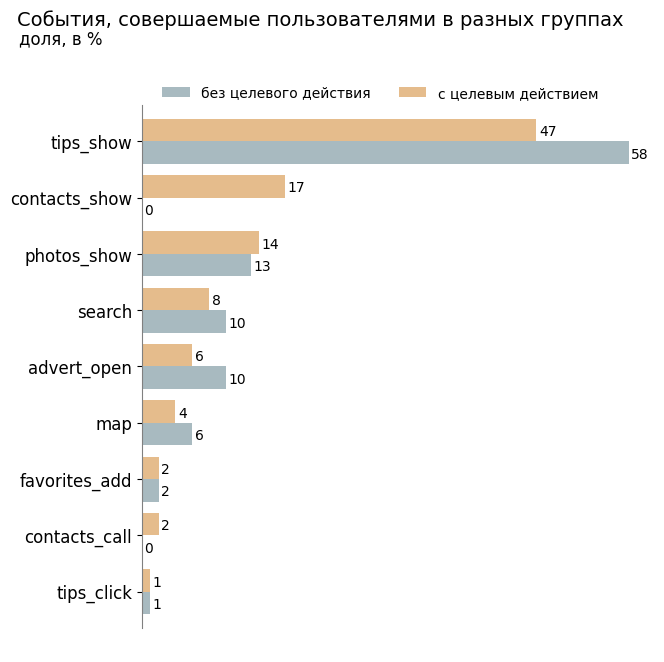

In [79]:
# построим график с долями событий
df1.plot.barh(width=0.8,
                color= [colors[0], colors[2]],
                figsize=(6.5, 6.8))

# убираем границы графика
axes = plt.gca() 
axes.spines['top'].set_visible(False)
axes.spines['bottom'].set_visible(False)
axes.spines['right'].set_visible(False)
axes.spines['left'].set_color('grey')
axes.tick_params(bottom=False)
# настройка осей
plt.yticks(fontsize= 12)
plt.xticks(color='white')
plt.xlim(0, 60)
plt.xlabel('')
plt.ylabel('')
plt.legend(ncol=2,  frameon=False, fontsize='10', bbox_to_anchor=(0.016, 0.985))

for i in axes.patches:
    axes.text(i.get_width()+0.3, i.get_y()+0.1,
            str(round((i.get_width()), 1)),
             fontsize=10,  
             color='black')
# отображение заголовка
plt.suptitle('События, совершаемые пользователями в разных группах', y=1.02, x=0.4,  fontsize=14)
plt.title('доля, в %', fontsize='12', y=1.1, x= -0.16)
plt.show()

Видно, что все пользователи чаще всего смотрят рекомендованные объявления. Но доля просмотров рекомендаций у пользователей с целевым действием ниже и у них выше доля просмотра фотографий. Пользователи без целевого события соответственно не совершают звонков и просмотров контактов. Доля кликов  рекомендованных объявлений и добавления в избранные в 2-х группах одинаково низкая, всего 1% 

**Вывод:** 
- пользователи в приложении совершают разные действия, имеется много различных сценарий сессий
- в 3-ке самых популярных сценарие - это сессии, состоящие из только одного действия, так на сессий только с tips_show  приходится - 25.8% от всех сценариев, на просмотр фото - 12.7%, а сессии, состоящие только из поиска - 7,3%
- те пользователи,  которые начались свой визит с просмотра карты, чаще всего следующим этапом начинают просматривать рекомендации, такое сочетание, 4 -й по полулярности сценарий
- сценарий, когда после просмотра рекомендованных объявлений пользователи переходят к просмотру контактов, является самым популярным сценарием сессий с целевм действием.
- те, пользователи, которые просматривают контакты чаще смотрят фотографии, а вот на клик по рекомендованным объявлениям не популярен у 2-х групп, всего 1% событий.

## Расчет метрик
<a id="metrica"></a>

#### DAU, WAU, Sticky Factor

In [80]:
# создадим новый столбец с номером недели, у нас есть данные за 4 недели
df['week_dt'] = pd.to_datetime(df['event_dt']).dt.isocalendar().week
# расчитаем DAU
print('DAU: ', round(df.groupby('event_dt')['user_id'].nunique().mean()))
# расчитаем WAU
print('WAU: ', round(df.groupby('week_dt')['user_id'].nunique().mean()))
# расчитаем Sticky Factor
print('Sticky Factor: ', round(df.groupby('event_dt')['user_id'].nunique().mean() / 
                               df.groupby('week_dt')['user_id'].nunique().mean() * 100, 2))

DAU:  279
WAU:  1382
Sticky Factor:  20.19


Sticky Factor характеризует лояльность и активность аудитории и уровень 20 %  является хорошим результатом

#### Конверсия (СR) 

In [81]:
# посчитаем конверсию события просмотр контактов по уникальным пользователям
print('CR: ', round(df[df['target_user'] == 1]['user_id'].nunique() / df['user_id'].nunique() * 100, 2))

CR:  22.85


In [82]:
# подготовим данные 
profiles = (df.groupby(['user_id'])
            .agg({'event_time':'first', 'source': 'first', 'target_user':'first'})
            .reset_index()
            .rename(columns={'event_time': 'first_ts'})
           )
profiles['month'] = pd.to_datetime(profiles['first_ts']).astype('datetime64[M]')
profiles['dt'] = pd.to_datetime(profiles['first_ts']).dt.date

target = (df[df['target_user_day'] == 1]
          .groupby(['event_time', 'user_id']).agg({'target_user_day':'first'})
          .reset_index()
          .rename(columns={'event_time': 'event_dt'})
          .drop('target_user_day', axis=1)
         )


In [83]:
# функция для расчёта конверсии
def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # определяем дату и время первой покупки для каждого пользователя
    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    # рассчитываем лайфтайм для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users' 
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis = 1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions: 
        dimensions = []

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

In [84]:
# функция для визуализации конверсии

def plot_conversion(conversion, conversion_history, horizon, colors, tit):
    # исключаем размеры когорт
    
    # первый график — кривые конверсии
    # задаём размер сетки для графиков
    plt.figure(figsize=(10, 4))

    # исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 1, 1)
    conversion.T.plot(grid=True, linewidth=1.5,  color= colors, ax=ax1)
    plt.legend(fontsize='10')
    plt.xlabel('лайфтайм', fontsize='10')
    plt.yticks(fontsize= 10)
    plt.xticks(fontsize= 10)
    plt.title('Конверсия пользователей' + tit, fontsize='14')

    plt.show()

In [85]:
# задаем момент анализа - 4 ноября 2019г
observation_date = datetime(2019, 11, 4).date()

# задаем горизонт анализа 
horizon_days = 14  

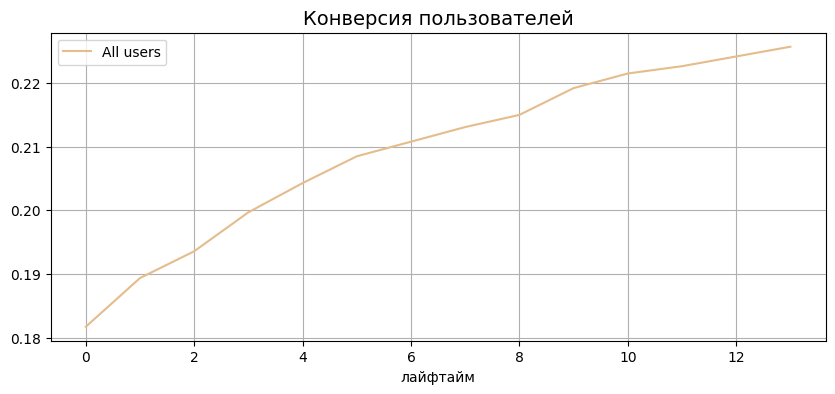

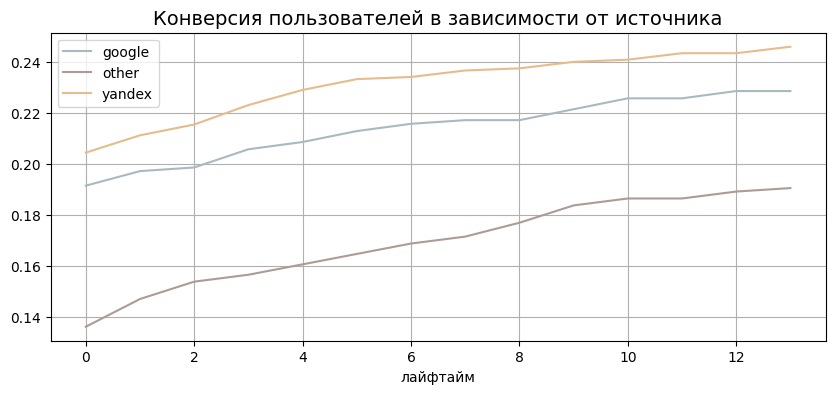

In [86]:
# посчитаем конверсию пользователей, вызовем функцию get_conversion
conversion, conversion_grouped, conversion_history = get_conversion(
    profiles,
    target,
    observation_date,
    horizon_days
    )
# посмотрим на графики конверсии пользователей, вызовем функцию plot_conversion

plot_conversion(conversion_grouped, conversion_history, horizon_days, colors[2], '')

# смотрим конверсию с разбивкой по устройствам
conversion, conversion_grouped, conversion_history = get_conversion(
    profiles,
    target,
    observation_date,
    horizon_days, 
    dimensions=['source']
    )
plot_conversion(conversion_grouped, conversion_history, horizon_days, 
                colors[:3], ' в зависимости от источника')


#### Retention rate

In [87]:
# функция для расчёта удержания

def get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # добавляем столбец payer в передаваемый dimensions список
    dimensions = ['target_user'] + dimensions

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        sessions[['user_id', 'event_time']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['event_time'] - result_raw['first_ts']
    ).dt.days

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу удержания
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # получаем таблицу динамики удержания
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

In [88]:
# функция для визуализации удержания
def plot_retention(retention, retention_history, horizon, colors):

    # задаём размер сетки для графиков
    plt.figure(figsize=(30, 7))

    # исключаем размеры когорт и удержание первого дня
    retention = retention.drop(columns=['cohort_size', 0])
    # в таблице динамики оставляем только нужный лайфтайм
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # если в индексах таблицы удержания только с целевым,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'target_user'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания целевых пользователей
    ax1 = plt.subplot(1, 2, 1)
    retention.query('target_user == 1').droplevel('target_user').T.plot(
        grid=True, color = colors, linewidth=3, ax=ax1
    )
    plt.legend(fontsize='14')
    plt.xlabel('Лайфтайм', fontsize='14')
    plt.yticks(fontsize= 14)
    plt.xticks(fontsize= 14)
    plt.title('Удержание пользователей c целевым действием', fontsize='20')

    # во второй ячейке строим кривые удержания без целевого
    # вертикальная ось — от графика из первой ячейки
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    retention.query('target_user == 0').droplevel('target_user').T.plot(
        grid=True, linewidth=3, color = colors, ax=ax2
    )
    plt.legend(fontsize='14')
    plt.xlabel('Лайфтайм', fontsize='14')
    plt.yticks(fontsize= 14)
    plt.xticks(fontsize= 14)
    plt.title('Удержание пользователей без целевого действия', fontsize='20')

    
    plt.show()

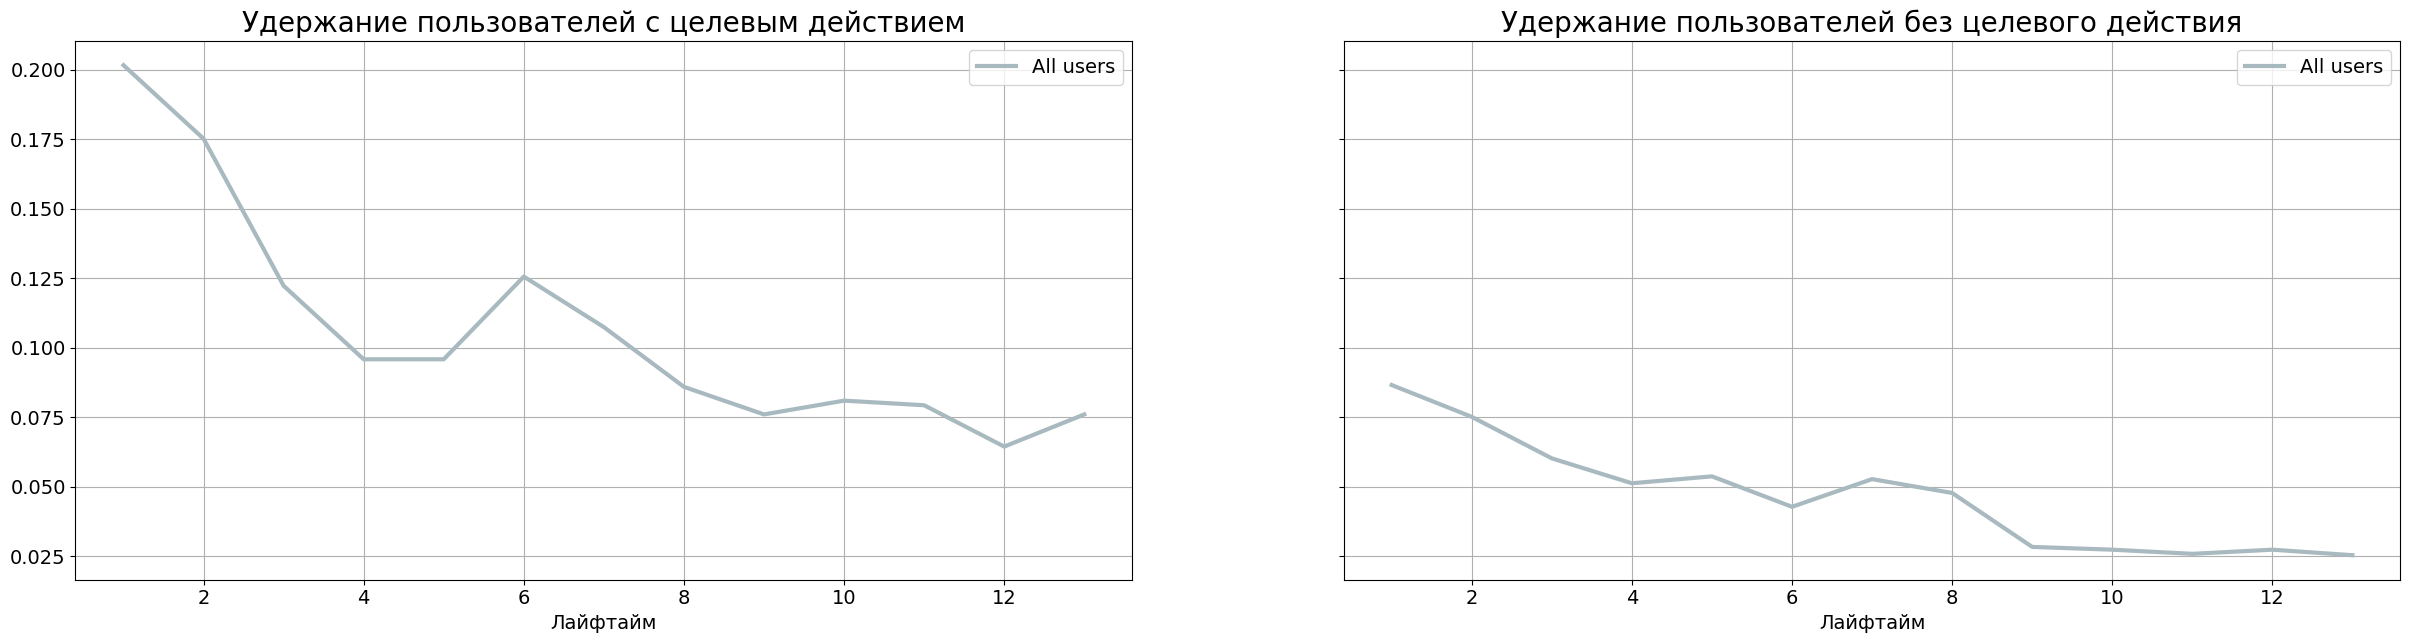

In [89]:
# посмотрим на  удержание пользователей 
retention, retention_grouped, retention_history = get_retention(
    profiles,
    df,
    observation_date,
    horizon_days,
     
)

plot_retention(retention_grouped, retention_history, horizon_days, colors[0])

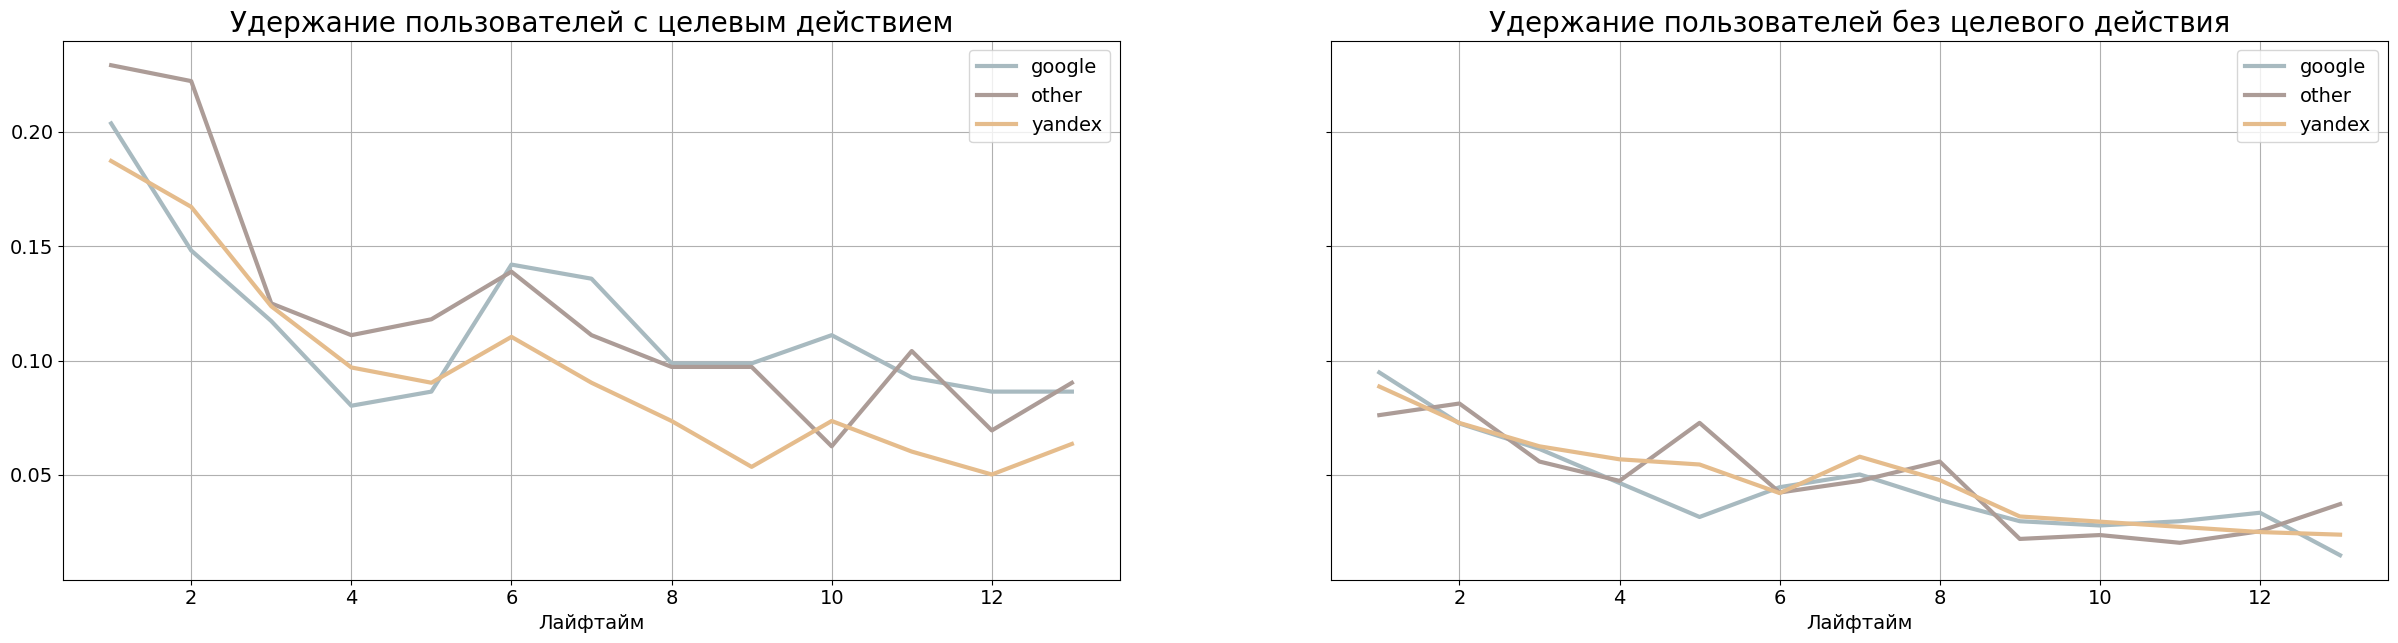

In [90]:
# посмотрим на  удержание пользователей по устройствам
retention, retention_grouped, retention_history = get_retention(
    profiles,
    df,
    observation_date,
    horizon_days,
     dimensions=['source']
)

plot_retention(retention_grouped, retention_history, horizon_days, colors[:3])

**Вывод:**
- DAU:  279, WAU:  1382, Sticky Factor:  20.19
- Конверсия - 22.85
- график конверсии растет и к 14 дню лайфтайма составляет около 22,5%
- наилучшая конверсий у пользователей из источника yandex, к 14 дню выше 24%
- наименьшая конверсия у пользователей из источника other, к 14 дню только 19%
- показания retention rate у пользователей с целевым действием выше, чем без него
- кривая retention rate снижается неравномерно, в 1-ю неделю жизни идет резкое снижение, во 2-ю неделю отток снижается более плавно
- удержание пользователей с целевым действием из источника yandex к 14-му дню ниже, по сравнению с остальными источниками. 

## Проверка гипотез
<a id="hypothesis"></a>

### Гипотеза 1

**Одни пользователи совершают действия tips_show и tips_click , другие — только tips_show . Проверим гипотезу: конверсия в просмотры контактов различается у этих двух групп.**

`H_0:` CR в просмотры контактов для группы с tips_show и tips_click = CR в просмотры контактов для группы только с tips_show

`H_1:` CR в просмотры контактов для группы с tips_show и tips_click ≠ CR в просмотры в контактов для группы только с tips_show

`alpha = 0.05`

In [91]:
users = list(df[(df['event_name'] == 'tips_show')]['user_id'].unique())
group_1 = (df[(df['user_id'].isin(users)) & (df['event_name'] == 'tips_click')]
                 .groupby('user_id', as_index=False)
                 .agg({'target_user': 'first'})
                )
users_group_1 = list(group_1['user_id'].unique()) 

group_2 = (df[(~ df['user_id'].isin(users_group_1)) & (df['event_name'] == 'tips_show')]
                 .groupby('user_id', as_index=False)
                 .agg({'target_user': 'first'})
                )

In [92]:
count_group_1 = group_1.shape[0]
count_group_2 = group_2.shape[0]
target_group_1 = group_1['target_user'].sum()
target_group_2 = group_2['target_user'].sum()
print('Кол-во пользователей с tips_show и tips_click: ', count_group_1)
print('Кол-во пользователей c целевым событием с tips_show и tips_click: ', target_group_1)
print('Кол-во пользователей только tips_show : ', count_group_2)
print('Кол-во пользователей c целевым событием только с  tips_show: ', target_group_2)
print('Конверсия в группе пользователей tips_show и tips_click ', round(target_group_1 / count_group_1 * 100, 2))
print('Конверсия в группе пользователей только с tips_show ', round(target_group_2 / count_group_2 * 100, 2))

Кол-во пользователей с tips_show и tips_click:  297
Кол-во пользователей c целевым событием с tips_show и tips_click:  91
Кол-во пользователей только tips_show :  2504
Кол-во пользователей c целевым событием только с  tips_show:  425
Конверсия в группе пользователей tips_show и tips_click  30.64
Конверсия в группе пользователей только с tips_show  16.97


In [93]:
# проверяем гипотезу
# критический уровень статистической значимости
alpha = 0.05 
successes = np.array([target_group_1, target_group_2])
trials = np.array([count_group_1, count_group_2])

# пропорция успехов в первой группе:
p1 = successes[0]/trials[0]
# пропорция успехов во второй группе:
p2 = successes[1]/trials[1]
# пропорция успехов в комбинированном датасете:
p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])
#разница пропорций в датасетах
difference = p1 - p2

#считаем статистику в ст.отклонениях стандартного нормального распределения
z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1]))
#задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
distr = st.norm(0, 1)

#считаем статистику в ст.отклонениях стандартного нормального распределения
z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1]))
#задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
distr = st.norm(0, 1)

p_value = (1 - distr.cdf(abs(z_value))) * 2
print('p-значение: ', p_value)
if (p_value < alpha):
    print("Отвергаем нулевую гипотезу: между долями есть значимая разница")
else:
    print("Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными")

p-значение:  9.218316554537864e-09
Отвергаем нулевую гипотезу: между долями есть значимая разница


Значение p_value близко к 0. Таким образом мы можем отвергнуть нулевую гипотезу. Анализ данных подтверждает наличие статистически значимых различий в конверсии в просмотры контактов у пользователей с tips_show и tips_click и у пользователей только с tips_show.

### Гипотеза 2

**Проверим гипотезу: средняя продолжительность сессий с целевым событием отличается от средней продолжительности сессий без целевого события.**


`H_0:` μ длительности сессий с целевым событием = μ длительности сессий без целевого событием

`H_1:` μ длительности сессий с целевым событием ≠ μ длительности сессий без целевого событием

`alpha = 0.05`

In [94]:
# создаем выборки из ранее сгруппированной таблицы target_session_time

target_session_duration = target_session_time[target_session_time['target_session'] == 'да']['session_time']
no_target_session_duration = target_session_time[target_session_time['target_session'] == 'нет']['session_time']

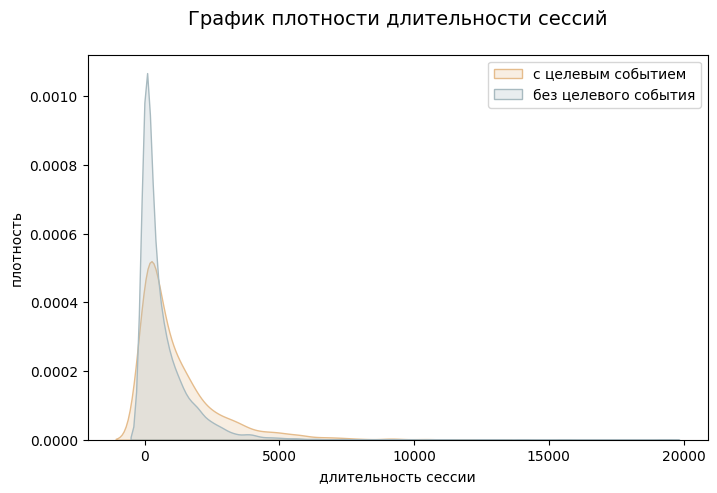

In [95]:
# посмотрим на распределение
plt.figure(figsize=(8, 5))
sns.kdeplot(target_session_duration, 
            shade=True, color= colors[2], label='c целевым событием')
sns.kdeplot(no_target_session_duration, color= colors[0], shade=True, label='без целевого события')
plt.legend(fontsize = '10')
plt.ylabel('плотность',  fontsize = '10')
plt.xlabel('длительность сессии', fontsize = '10')
plt.yticks(fontsize = '10')
plt.xticks(fontsize = '10')
plt.title('График плотности длительности сессий\n ', fontsize = '14')
plt.show()

In [96]:
# применим метод describe
target_source_session_time.groupby(['target_session'])['session_time']\
.describe(percentiles=[.1, .25, .75, .90, .95, .99]).T

target_session            да           нет
count            1703.000000   8665.000000
mean             1206.604228    686.914830
std              1591.877390   1075.487812
min                 0.000000      0.000000
10%                 4.000000      0.000000
25%               141.000000      6.000000
50%               654.000000    292.000000
75%              1629.500000    935.000000
90%              3159.800000   1887.200000
95%              4398.800000   2608.000000
99%              7397.240000   4841.760000
max             12545.000000  19318.000000

Распределение ненормальное, у нас есть выбросы в 2-х выборках, а также есть сессий с 0 сек, больше таких сессий без целевого события. 

Учитывая, выбросы и ненормальное распределение возможно применить непараметрический статестический критерий Манна-Уитни. Но критерий Манна-Уитни проверяет только равенство распределений. Этот критерий не подходит для сравнения средних или медиан ([статья на Хабре](https://habr.com/ru/companies/avito/articles/709596/)). Размер выборок у нас достаточен, чтобы применить t-критерий Стьюдента.  

Проведем 2 теста, посмотрим на полученные значения p_value.  
Проведем тесты, не удаляя выбросы

In [97]:
# применим t-критерий Стьюдента к полученным выборкам
results= st.ttest_ind(target_session_duration, no_target_session_duration, equal_var=False)
# alpha = задайте значение уровня значимости
alpha = 0.05
# вывод значения p-value на экран 
print('p-значение:', results.pvalue)
# условный оператор с выводом строки с ответом
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение: 1.1295428838640128e-36
Отвергаем нулевую гипотезу


In [98]:
# применим статистический критерий Манна-Уитни к полученным выборкам
p_value = stats.mannwhitneyu(target_session_duration, no_target_session_duration)[1]
print('p-значение:', p_value)
if p_value < 0.05:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')


p-значение: 4.220597570644722e-61
Отвергаем нулевую гипотезу


Таким образом и t-критерий Стьюдента, и критерий Манна-Уитни показали p_value близкое к 0. Таким образом мы можем отвергнуть нулевую гипотезу. Анализ данных подтверждает наличие статистически значимых различий в средней длительности сессий с просмотром контактов и без. 

# Вывод
<a id="finish"></a>

В ходе исследования данных мобильного приложения с 07.10.2019 по 03.11.2019г. удалось выяснить следующее: 
- за это промежуток времени приложением воспользовались 4293 пользователи, 45% из них пришли из источника yandex, 26% - google и у 29 %  - источник other
-  пользователи совершили 74197 событий, более половины (54 %) приходится на "увидел рекомендованное объявление", на "просмотр контактов" приходится 16,4 % событий
- при принятии за таймаут сессии время 30 мин, количество сессий, совершенных пользователями, составило - 10368, из них 16,4% составляют сессии с целевым действием (просмотр контактов)
- доля сессий с длительностью 0 сек и с 1 действием  - 20 %, чаще всего такие сессии происходят у пользователей из источника other
- средняя длительность сессии составляет почти 13 мин.(772 сек), медиана  около 6 мин. (335 сек), продолжительней сессии у пользователей из источника yandex (медианна 402 сек), google(350сек.), а у other всего 236 сек
- у пользователей из источника google в среднем больше событий и сессий на пользователя 
- длительность сессий зависит и от целевого события, в ходе проверки гипотезы выявили статистически значимые различия в средней длительности сессий с просмотром контактов и без. Средняя длительность сессий с целевым действием - 1207 сек (20 мин), без целевого - 687 сек (чуть более 11 мин), медианны значения также отличаются более, чем в 2 раза 654 сек (11 мин) и 292 сек (почти 5 мин)
- в целевых сессиях также отмечается больше событий, чем не в целевых действиях
- конверсия составила - 22.85%, лучше всего показатели у пользователей из источника yandex, стоит обратить внимание на низкую конверсию у пользоателей с источником установки приложения other
- пользователи по-разному взаимодействуют с приложением, но стоит отметить, что большая часть сессий сотоит из однотипных действий в виде или просмотра рекомендованных объявлений (25.8% от всех сценариев) или просмотра фотографий (12.7%), возможно такие пользователи зашли в приложение без конкретной цели и просматривают объявления и фотографии ради интереса. И если попадается что-то нужное, пользователи решают приобрести товар, такой сценарий является самым популярным у сессий с целевым действием. Пользователи также часто пользуются сочетанием "просмотр карты → увидел рекомендации", часть таких заканчиваются просмотром контактов
- доля просмотров контактов в группе пользователей tips_show и tips_click составила 30.6 %, а вот у пользователей, не совершающих tips_click, а только tips_show около 20%, в ходе проверки гипотез мы выявили наличие статистически значимых различий в конверсии у таких групп. Но доля tips_click среди всех событий незначительная, около 1%

Рекомендации:
- выявить не могут ли технические причины со стороны приложения приводить к большому количеству отказных сессий
- определить причину низкой активности у пользователей с источником other, так как доля таких пользователей вторая по численности, но они показывают низкую конверсию по сравнению с остальными. Возможно стоит подумать о модернизации приложения и сделать его более удобным для пользования
- усовершенствовать рекомендательные системы, чтобы рекомендации чаще удовлятворяли пожеланиям пользователей. На это указывает низкая доля кликов на рекомендованные объявления.

